# Evaluation of models on test data

In [1]:
import util
import plotting
import evaluation
import preprocessing

import numpy as np
import pandas as pd
from skimage.color import label2rgb
from skimage import filters, measure, segmentation

import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)

from tqdm import tqdm
import tensorflow as tf

In [2]:
#Define GPU device where the code will run on
gpu = tf.config.list_physical_devices('GPU')[0]
print(gpu)
tf.config.experimental.set_memory_growth(gpu, True)
gpu = tf.device('GPU:0/')

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## No preprocessing, different batch sizes

In [3]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

labels = util.load_h5(data_path, 'labels')
print('Labels:', labels.shape)


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/labels.h5
Converting to array
Labels: (37000, 128, 128)


In [4]:
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'ref')
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])
folder_name = [folder_name[i] for i in idx_sort]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b8/model.h5

Loading H:/Santi/Models/ref_f8_c9_b16/model.h5

Loading H:/Santi/Models/ref_f8_c9_b32/model.h5

Loading H:/Santi/Models/ref_f8_c9_b256/model.h5
Done.

Loading H:/Santi/Models/ref_f8_c9_b8/history

Loading H:/Santi/Models/ref_f8_c9_b16/history

Loading H:/Santi/Models/ref_f8_c9_b32/history

Loading H:/Santi/Models/ref_f8_c9_b256/history
Done.

Loading H:/Santi/Models/ref_f8_c9_b8/frames_test

Loading H:/Santi/Models/ref_f8_c9_b16/frames_test

Loading H:/Santi/Models/ref_f8_c9_b32/frames_test

Loading H:/Santi/Models/ref_f8_c9_b256/frames_test
Done.


In [5]:
input_test, output_test, pred_output_test = {}, {}, {}
labels_test, pred_labels_test = {}, {}

for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  labels_test[model_name] = labels[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  pred_labels_test[model_name] = evaluation.label(pred_output_test[model_name])  

del output_data, labels, input_data

  0%|                                                                                                                                                                          | 0/4 [00:00<?, ?it/s]


Model: ref_f8_c9_b8


 25%|████████████████████████████████████████▌                                                                                                                         | 1/4 [00:09<00:28,  9.37s/it]


Model: ref_f8_c9_b16


 50%|█████████████████████████████████████████████████████████████████████████████████                                                                                 | 2/4 [00:16<00:15,  7.98s/it]


Model: ref_f8_c9_b32


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 3/4 [00:23<00:07,  7.55s/it]


Model: ref_f8_c9_b256


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:30<00:00,  7.63s/it]


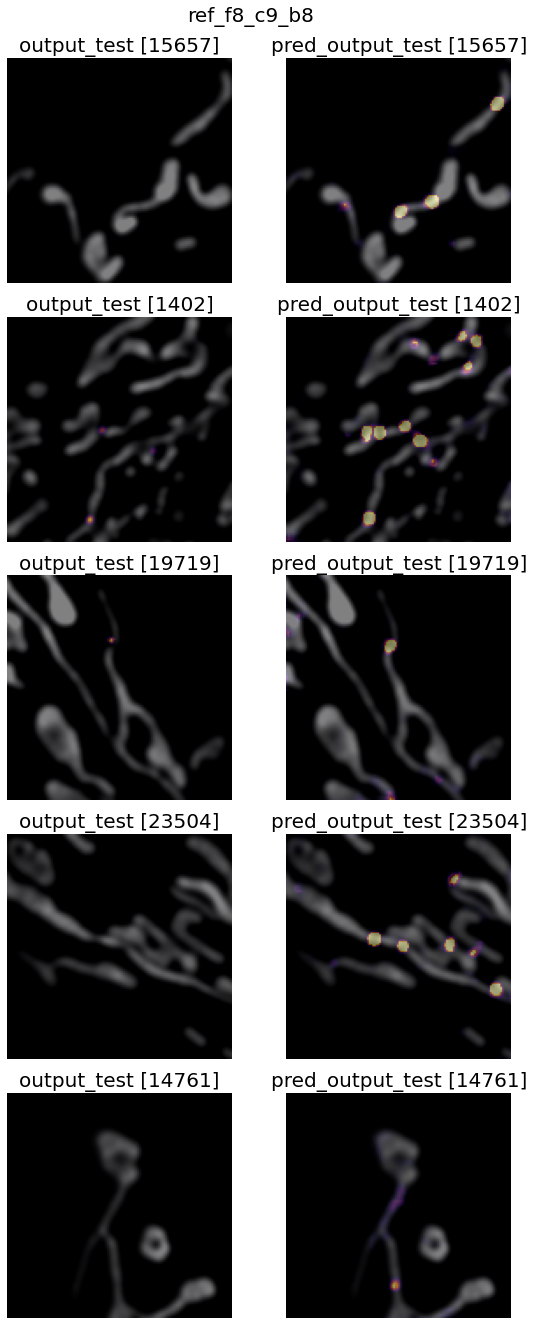

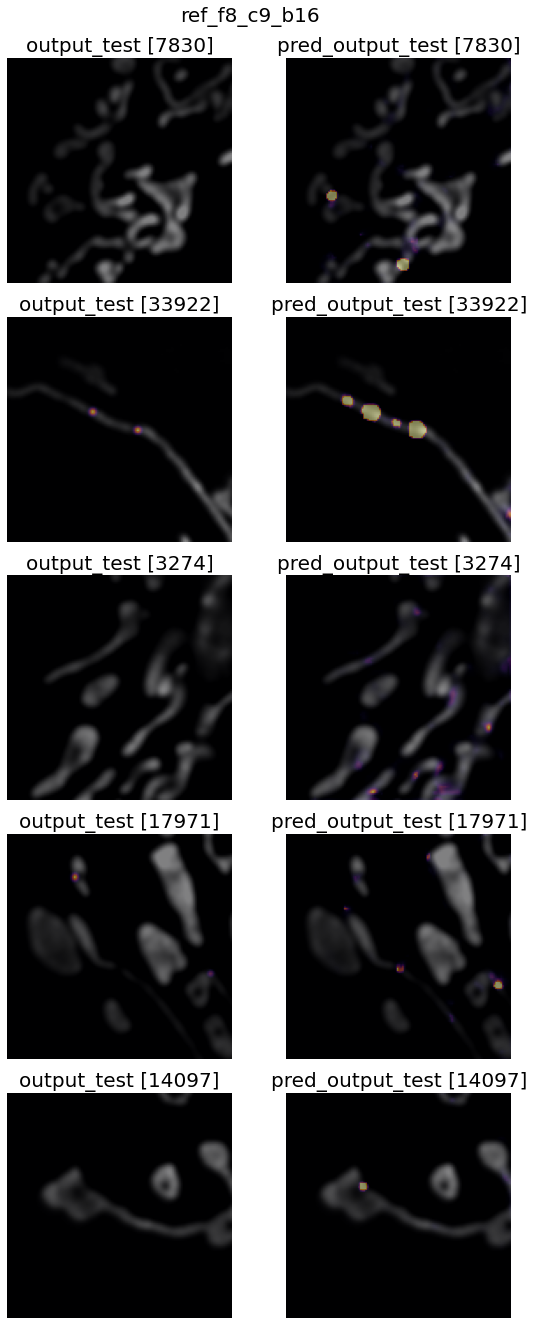

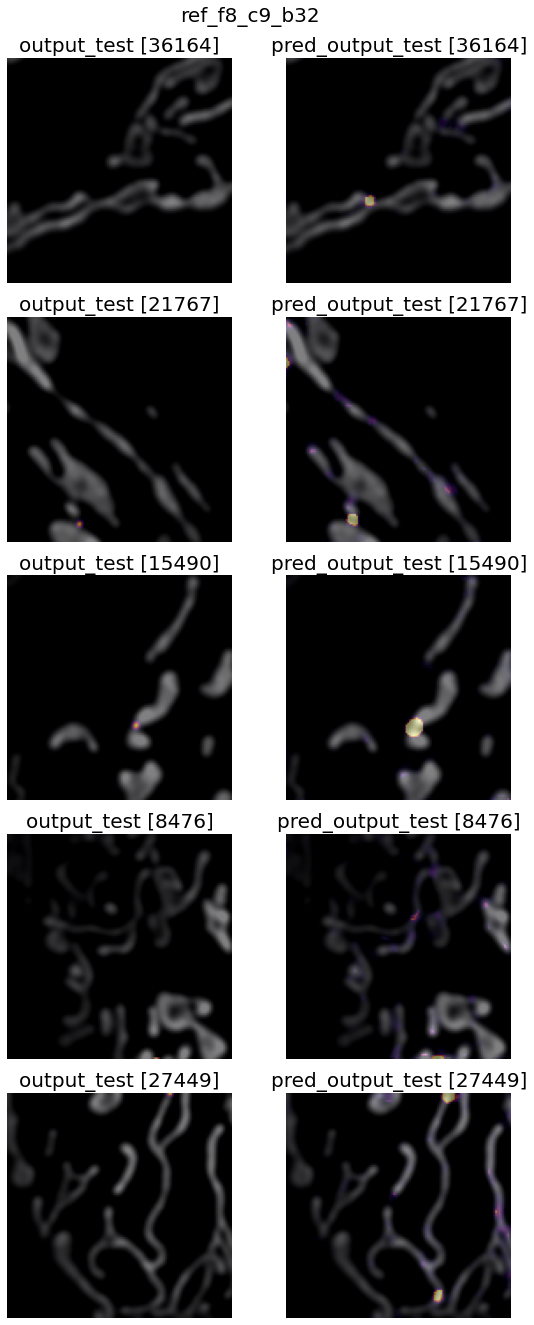

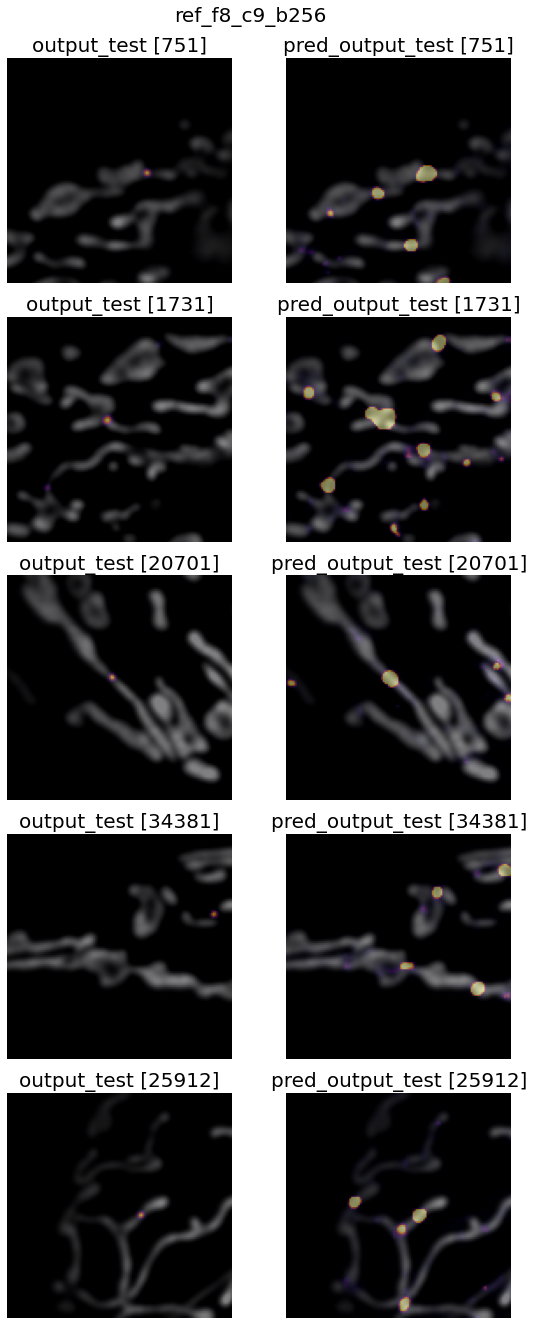

In [6]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [7]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(model), folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b8/metrics

Loading H:/Santi/Models/ref_f8_c9_b16/metrics

Loading H:/Santi/Models/ref_f8_c9_b32/metrics

Loading H:/Santi/Models/ref_f8_c9_b256/metrics
Done.


### All metrics

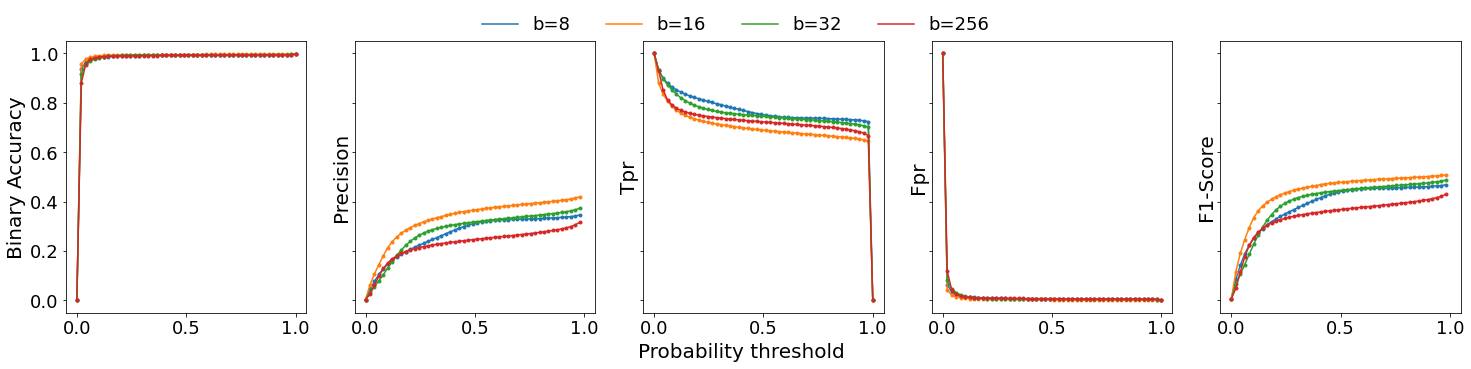

In [8]:
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_metrics))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)

for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name.title())
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], color=color)[0] for color in colors], ['b='+model_name.split('_b')[-1] for model_name in folder_name], 
           loc='upper center', ncol=4, framealpha=0)
plt.show()

### metricAtMaxThreshold

In [9]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][-2]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

ref_f8_c9_b8  ref_f8_c9_b16  ref_f8_c9_b32  ref_f8_c9_b256
binary accuracy      0.994731       0.996018       0.995367        0.994197
precision            0.345865       0.419817       0.372975        0.316267
TPR                  0.723543       0.645070       0.700927        0.667311
FPR                  0.004397       0.002857       0.003707        0.004731
F1-score             0.468013       0.508620       0.486875        0.429144

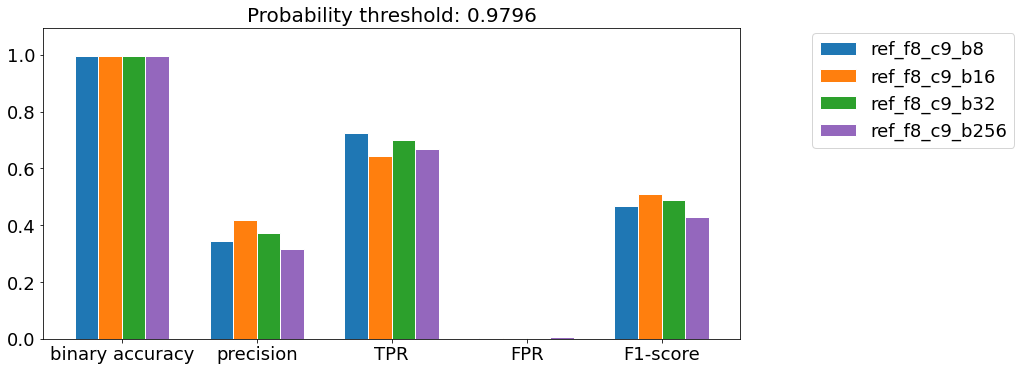

In [10]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
ax.set_title('Probability threshold: %.4f'%thresholds[-2], size=20)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'ref_f8_c9_b8': 0.003203017776076858, 'ref_f8_c9_b16': 0.0031948110219594595, 'ref_f8_c9_b32': 0.003136093552048142, 'ref_f8_c9_b256': 0.0032687130489864867}


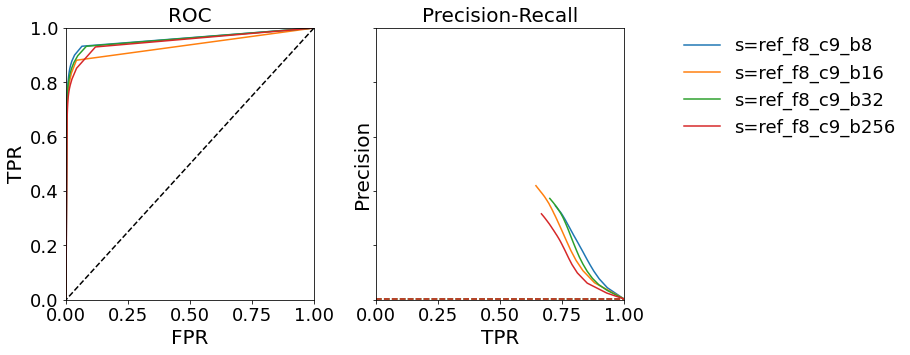

In [11]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

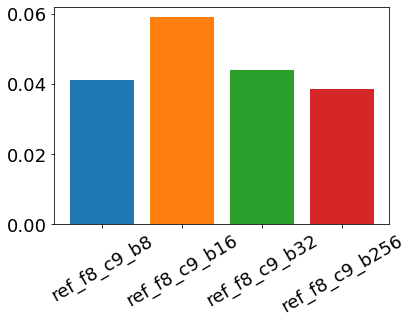

In [12]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

### Labels binary overlap

Fission stats:  [1 0 0]


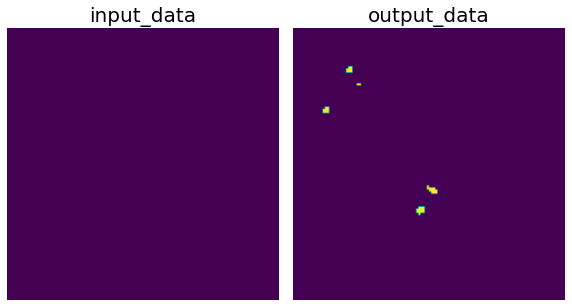

In [74]:
frame = 100
print('Fission stats: ', evaluation.fissionStats(labels_test[model_name][frame], pred_labels_test[model_name][frame]))
plotting.plot_comparison(labels_test[model_name][frame], pred_labels_test[model_name][frame], cmap='viridis')
plt.show()

In [75]:
true_labels, pred_labels = labels_test[model_name][frame], pred_labels_test[model_name][frame]

TP, FN = 0, 0
used_pred_labels = np.zeros(pred_labels.shape, dtype=bool) #Mask of labels
if np.any(true_labels!=0):
  for true_fission in np.unique(true_labels)[1:]: #Positives, first label is the bg_label=0
      overlapping_fissions = np.unique(pred_labels[true_labels==true_fission]) 
      overlapping_fissions = overlapping_fissions[overlapping_fissions!=0] #All of the pred_labels that overlap with true_fission
      if len(overlapping_fissions)>0: 
          TP += 1  #Add a TP if there is at least one pred_label that overlaps with the true fission
          for pred_fission in overlapping_fissions:
              used_pred_labels[pred_labels==pred_fission] = True #Register used labels in a mask
      else:
          FN += 1 #Add a FN if the true fission was not detected
  remaining_pred_labels = np.unique(pred_labels[~used_pred_labels]) #Keep only pred_labels that are not in contact with true_labels
  remaining_pred_labels = remaining_pred_labels[remaining_pred_labels!=0]
  if len(remaining_pred_labels)>0:
    FP = len(remaining_pred_labels) #Remove bg_label=0 (index=0) and add the remaining_pred_labels as FP
  else:
    FP = 0
    
print(TP, FP, FN)

0 5 0


In [13]:
fissionStats = {}
for model_name in labels_test:
  fissionStats[model_name] = evaluation.fissionStatsStack(labels_test[model_name], pred_labels_test[model_name])

  0%|                                                                                                                                                                       | 0/7400 [00:00<?, ?it/s]C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\evaluation.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array([TP, FP, FN])
  0%|                                                                                                                                                                       | 0/7400 [00:00<?, ?it/s]


TypeError: ufunc 'add' output (typecode 'O') could not be coerced to provided output parameter (typecode 'h') according to the casting rule ''same_kind''

In [17]:
pd.DataFrame(fissionStats)

array([0, 0, 0], dtype=int16)

## MitoProc, different batch sizes

In [98]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'MitoProc')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)


Loading H:/Santi/Data/MitoProc.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


In [99]:
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'mp')
folder_name = [model_name for model_name in folder_name if '_s' not in model_name]
idx_sort = np.argsort([int(model_name.split('_b')[-1]) for model_name in folder_name])
folder_name = [folder_name[i] for i in idx_sort]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/mp_f8_c9_b8/model.h5

Loading H:/Santi/Models/mp_f8_c9_b16/model.h5

Loading H:/Santi/Models/mp_f8_c9_b32/model.h5

Loading H:/Santi/Models/mp_f8_c9_b256/model.h5
Done.

Loading H:/Santi/Models/mp_f8_c9_b8/history

Loading H:/Santi/Models/mp_f8_c9_b16/history

Loading H:/Santi/Models/mp_f8_c9_b32/history

Loading H:/Santi/Models/mp_f8_c9_b256/history
Done.

Loading H:/Santi/Models/mp_f8_c9_b8/frames_test

Loading H:/Santi/Models/mp_f8_c9_b16/frames_test

Loading H:/Santi/Models/mp_f8_c9_b32/frames_test

Loading H:/Santi/Models/mp_f8_c9_b256/frames_test
Done.


In [100]:
input_test, output_test, pred_output_test = {}, {}, {}
for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]


Model: mp_f8_c9_b8


 25%|██████████████████████████████▎                                                                                          | 1/4 [00:02<00:08,  2.85s/it]


Model: mp_f8_c9_b16


 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:05<00:05,  2.84s/it]


Model: mp_f8_c9_b32


 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:08<00:02,  2.84s/it]


Model: mp_f8_c9_b256


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.85s/it]


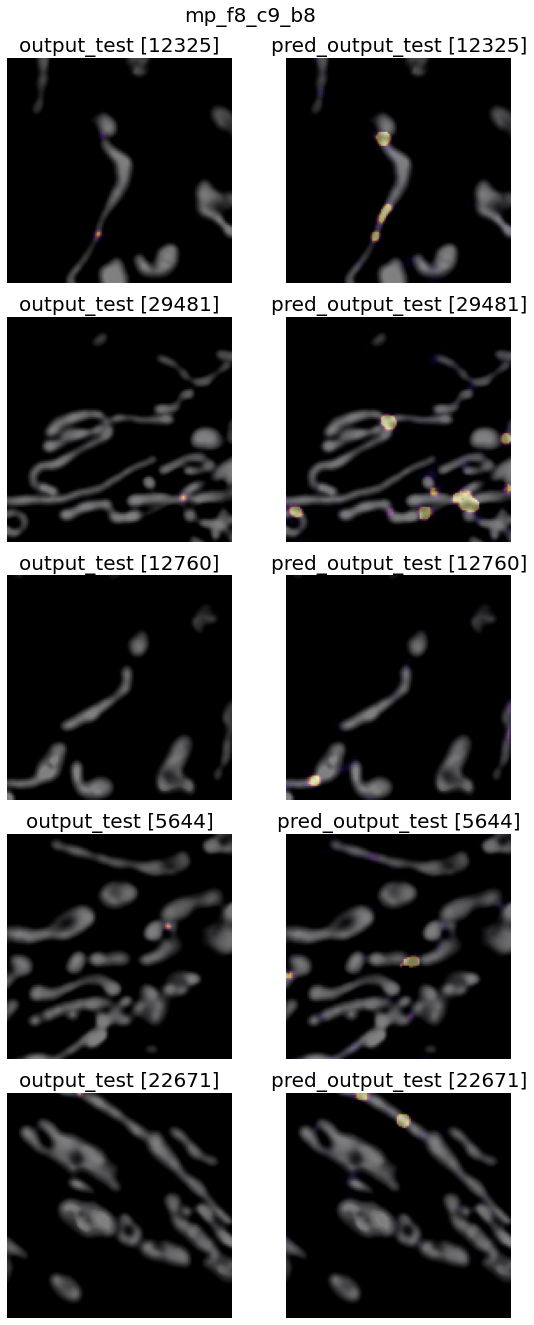

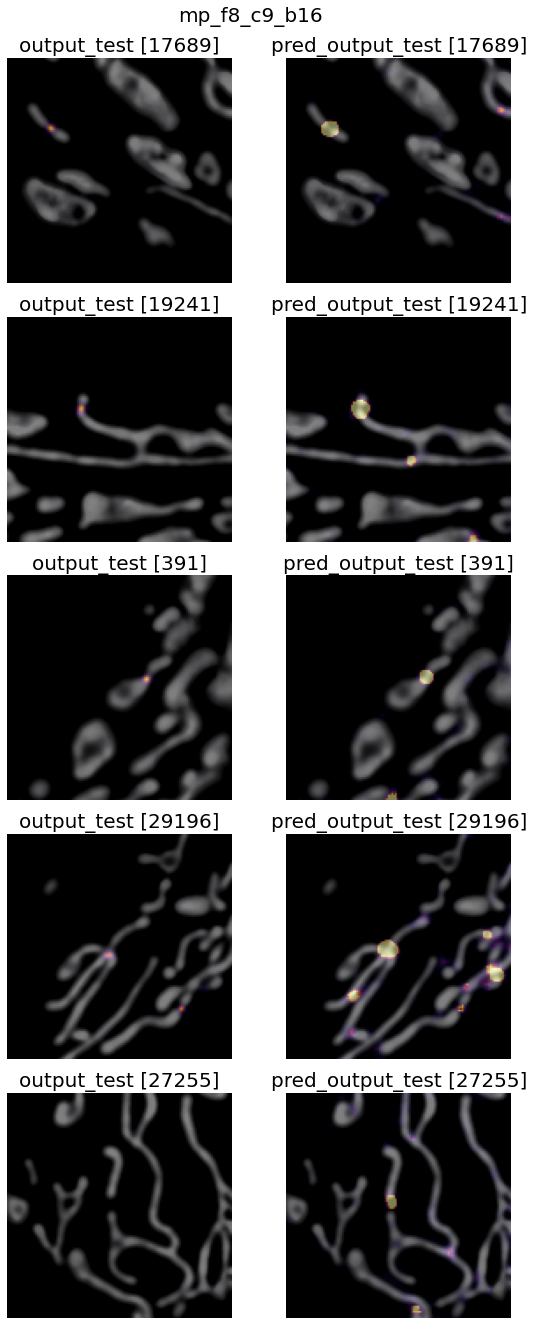

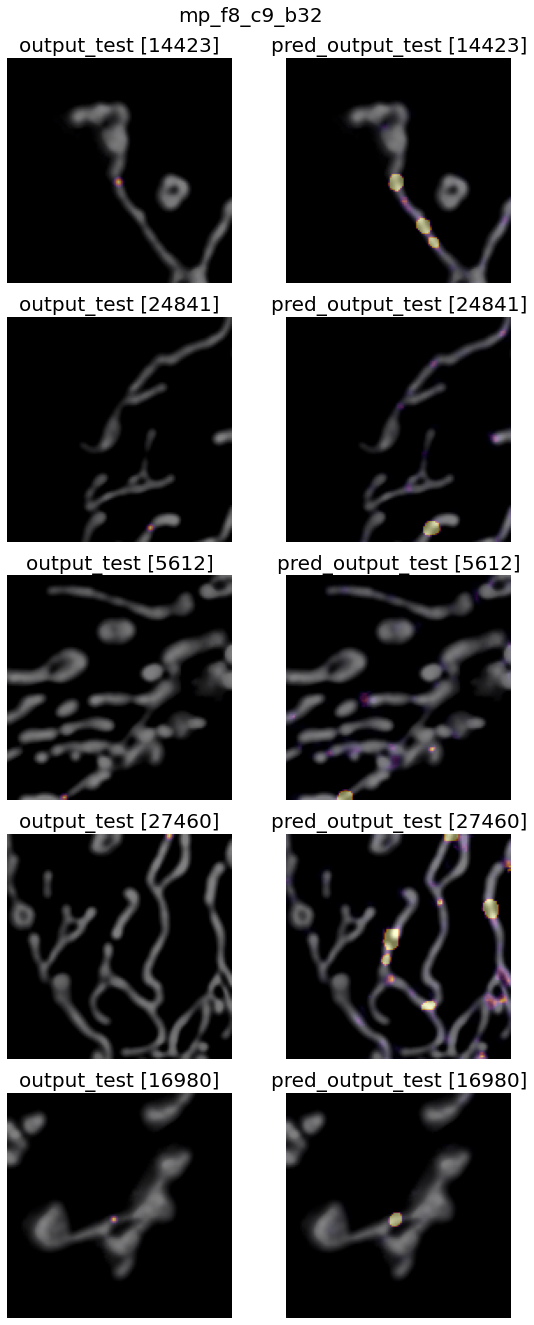

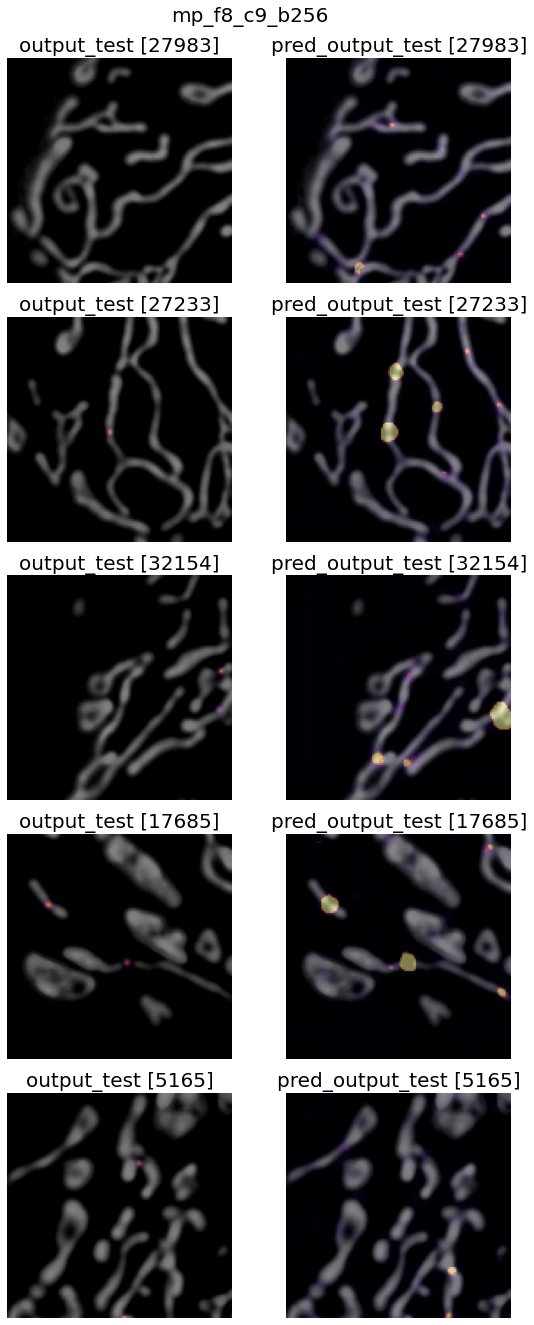

In [101]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [102]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/mp_f8_c9_b8/metrics

Loading H:/Santi/Models/mp_f8_c9_b16/metrics

Loading H:/Santi/Models/mp_f8_c9_b32/metrics

Loading H:/Santi/Models/mp_f8_c9_b256/metrics
Done.


### All metrics

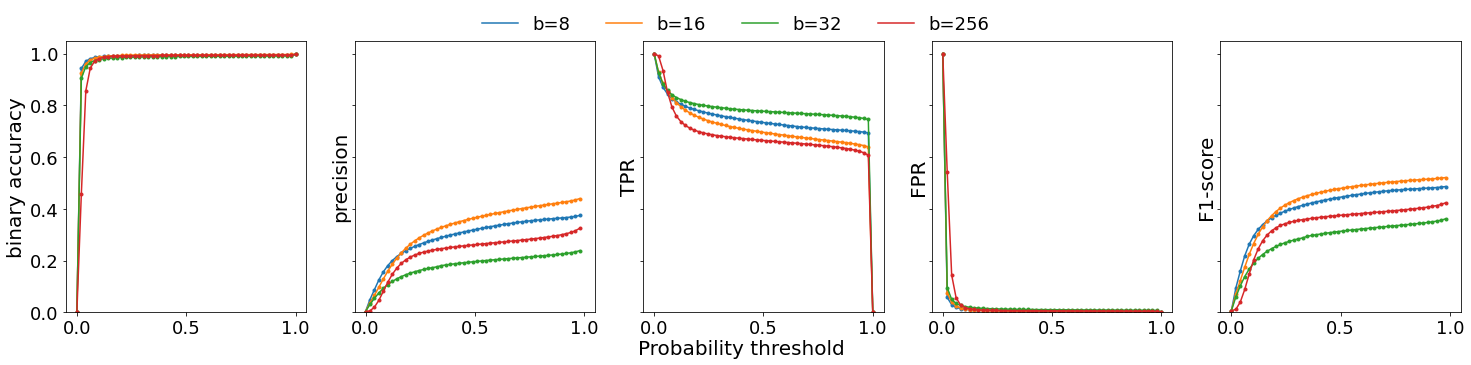

In [103]:
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_metrics))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)

for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0.01, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], color=color)[0] for color in colors], ['b='+model_name.split('_b')[-1] for model_name in folder_name], 
           loc='upper center', ncol=4, framealpha=0)

plt.show()

### metricAtMaxThreshold

In [104]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][-2]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

mp_f8_c9_b8  mp_f8_c9_b16  mp_f8_c9_b32  mp_f8_c9_b256
binary accuracy     0.995174      0.996322      0.991400       0.994677
precision           0.374470      0.439567      0.238522       0.324960
TPR                 0.693245      0.639223      0.745263       0.607050
FPR                 0.003828      0.002557      0.007793       0.004072
F1-score            0.486271      0.520919      0.361383       0.423315

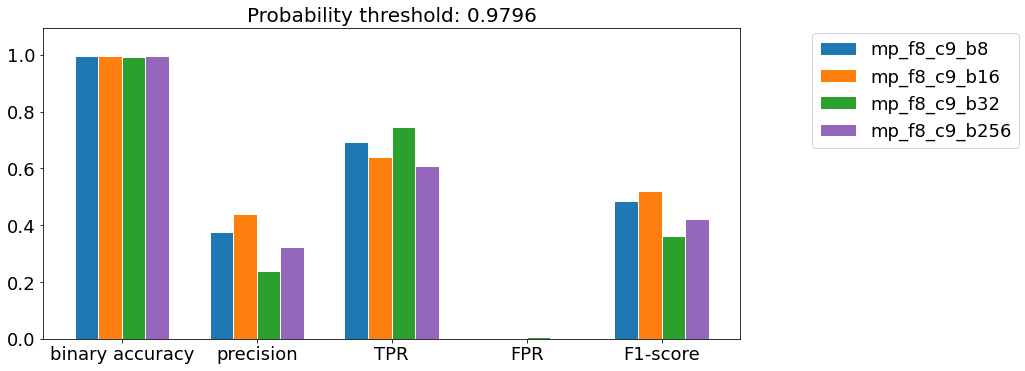

In [105]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
ax.set_title('Probability threshold: %.4f'%thresholds[-2], size=20)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'mp_f8_c9_b8': 0.0032943890545819258, 'mp_f8_c9_b16': 0.003128216717694257, 'mp_f8_c9_b32': 0.0032648447397592905, 'mp_f8_c9_b256': 0.003218532252956081}


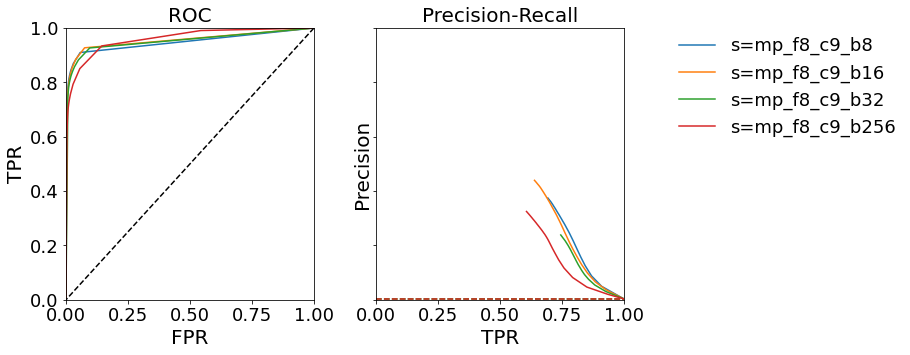

In [106]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

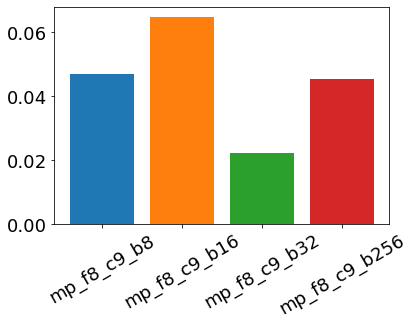

In [107]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

## MitoProc vs Mito, batch_size=16

In [108]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'MitoProc')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = util.load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)


Loading H:/Santi/Data/MitoProc.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)


In [109]:
model_path = base_dir + 'Models/'
batch_size = 16
folder_name = ['ref_f8_c9_b%i'%batch_size, 'mp_f8_c9_b%i'%batch_size]
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b16/model.h5

Loading H:/Santi/Models/mp_f8_c9_b16/model.h5
Done.

Loading H:/Santi/Models/ref_f8_c9_b16/history

Loading H:/Santi/Models/mp_f8_c9_b16/history
Done.

Loading H:/Santi/Models/ref_f8_c9_b16/frames_test

Loading H:/Santi/Models/mp_f8_c9_b16/frames_test
Done.


In [110]:
input_test, output_test, pred_output_test = {}, {}, {}
for model_name in tqdm(model, total=len(model)):
  print('\nModel: %s'%model_name)
  input_test[model_name] = input_data[frames_test[model_name]]
  output_test[model_name] = output_data[frames_test[model_name]]
  pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

  0%|                                                                                                                                 | 0/2 [00:00<?, ?it/s]


Model: ref_f8_c9_b16


 50%|████████████████████████████████████████████████████████████▌                                                            | 1/2 [00:02<00:02,  2.83s/it]


Model: mp_f8_c9_b16


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.81s/it]


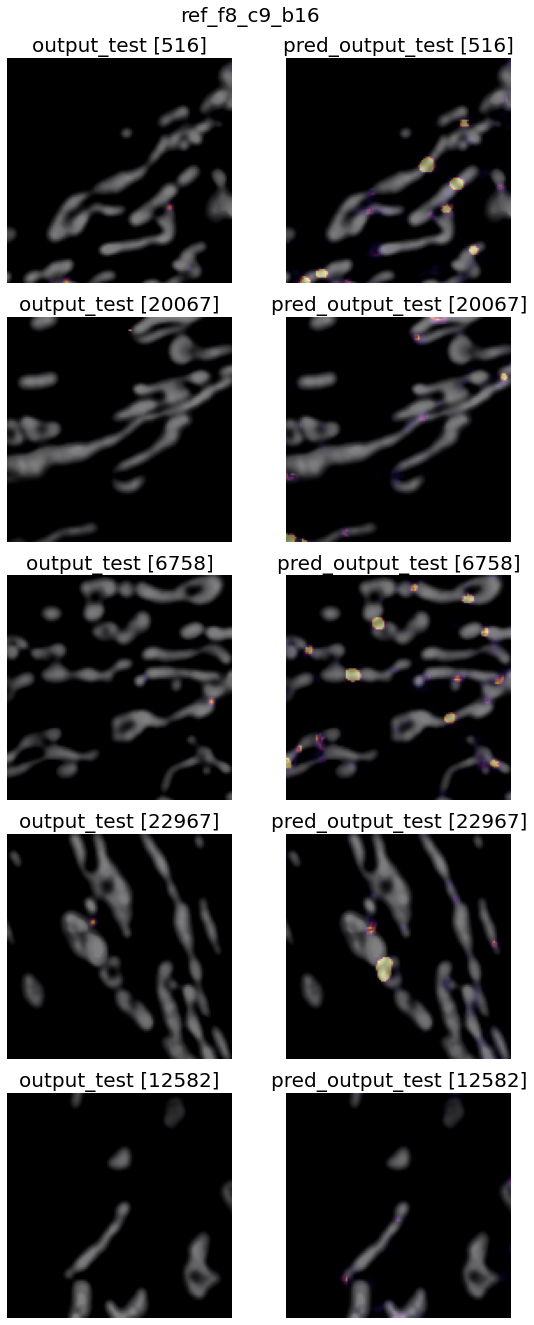

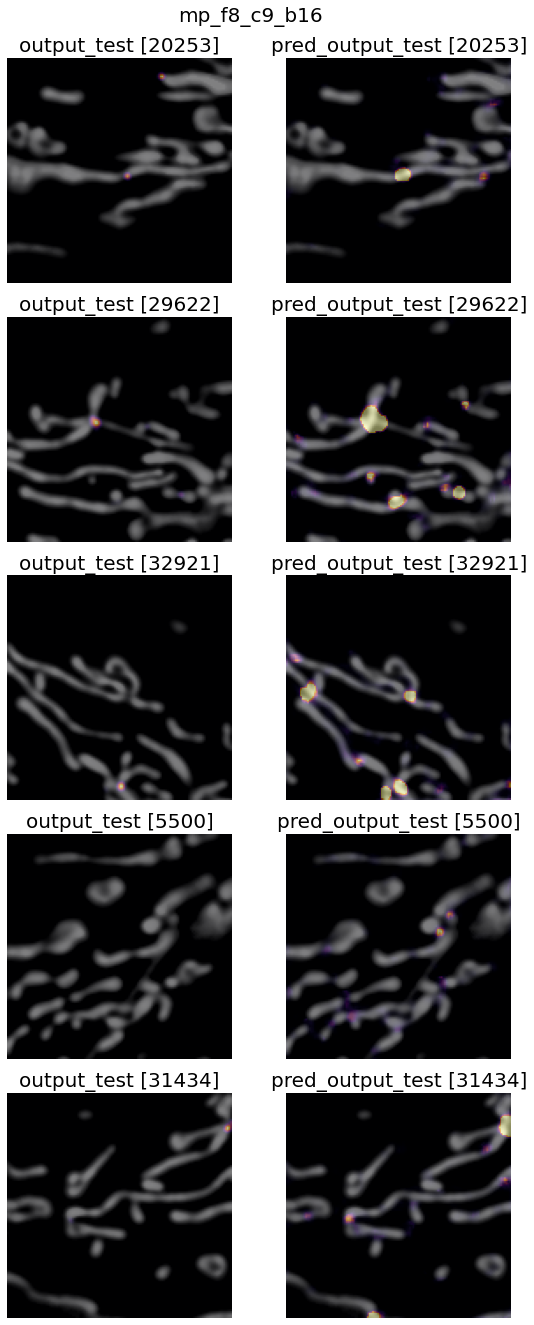

In [111]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name)
  plt.show()
  print('\n')

In [112]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/ref_f8_c9_b16/metrics

Loading H:/Santi/Models/mp_f8_c9_b16/metrics
Done.


### All metrics

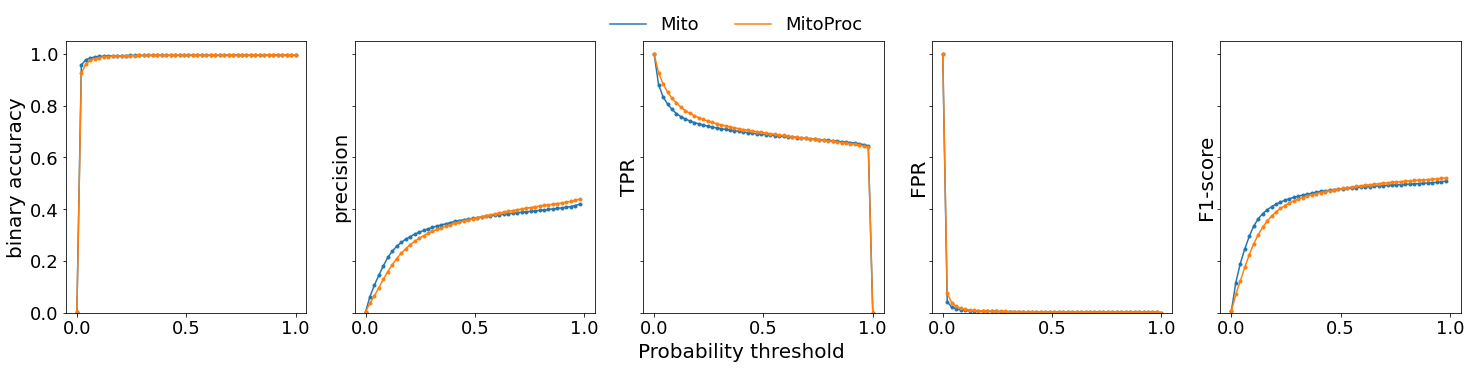

In [113]:
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_metrics))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)

for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], color=color)[0] for color in colors], ['Mito', 'MitoProc'],
           loc='upper center', ncol=4, framealpha=0)

plt.show()

### metricAtMaxThreshold

In [114]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][-2]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

ref_f8_c9_b16  mp_f8_c9_b16
binary accuracy       0.996018      0.996322
precision             0.419817      0.439567
TPR                   0.645070      0.639223
FPR                   0.002857      0.002557
F1-score              0.508620      0.520919

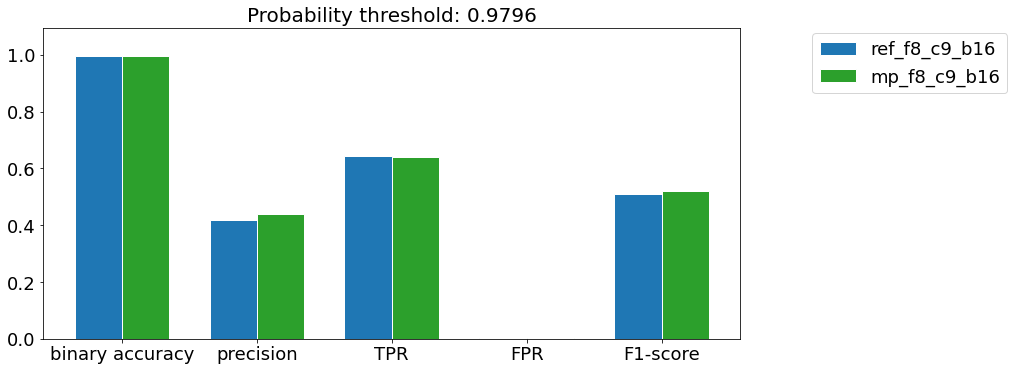

In [115]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
ax.set_title('Probability threshold: %.4f'%thresholds[-2], size=20)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'ref_f8_c9_b16': 0.0031948110219594595, 'mp_f8_c9_b16': 0.003128216717694257}


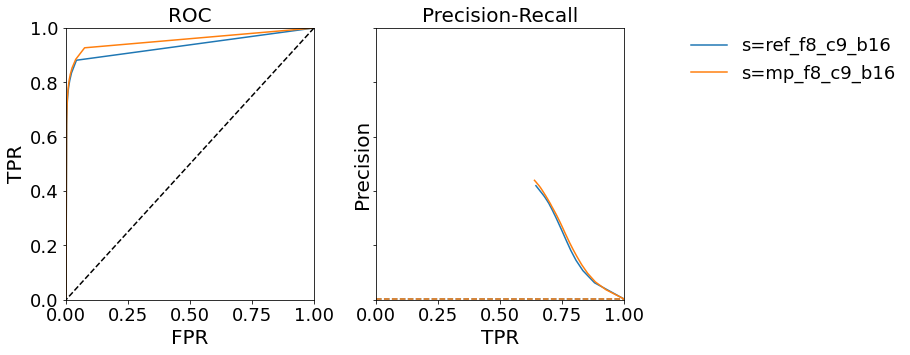

In [116]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

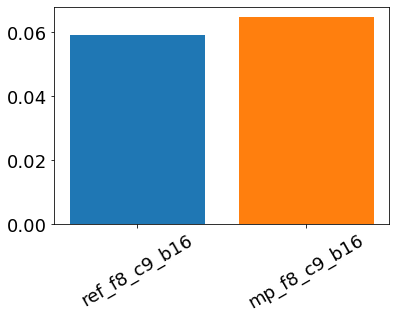

In [117]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

## Mito & WatProc, different spot sizes

Dilating fissions with a disk-shaped gaussian kernel improved F1-score in 14%. The highest mean intensity threshold of 22.2 had the best performance.

In [180]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

optimal_sigma = util.load_pkl(data_path, 'optimal_sigma')
threshold = util.load_pkl(data_path, 'mean_intensity_threshold')
nb_sigmas = optimal_sigma.shape[0]


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/optimal_sigma

Loading H:/Santi/Data/mean_intensity_threshold


In [12]:
#Outputs
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'wp')
folder_name = [model_name for model_name in folder_name if 'mp' not in model_name and 'aug' not in model_name] 
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/wp_f8_c9_b16_s1.9_t3.5/model.h5

Loading H:/Santi/Models/wp_f8_c9_b16_s2.1_t11.3/model.h5

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t16.0/model.h5

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t19.1/model.h5

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t22.2/model.h5
Done.

Loading H:/Santi/Models/wp_f8_c9_b16_s1.9_t3.5/history

Loading H:/Santi/Models/wp_f8_c9_b16_s2.1_t11.3/history

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t16.0/history

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t19.1/history

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t22.2/history
Done.

Loading H:/Santi/Models/wp_f8_c9_b16_s1.9_t3.5/frames_test

Loading H:/Santi/Models/wp_f8_c9_b16_s2.1_t11.3/frames_test

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t16.0/frames_test

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t19.1/frames_test

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t22.2/frames_test
Done.


In [ ]:
with gpu:
  input_test, output_test, pred_output_test = {}, {}, {}

  for model_name, s, t in zip(folder_name, optimal_sigma, threshold):
    print('\nModel: %s'%model_name)
    #Outputs
    output_data = util.load_h5(data_path, 'WatProc_s%.1f_t%.1f'%(s, t))
    print('Outputs:', output_data.shape)
    input_test[model_name] = input_data[frames_test[model_name]]
    output_test[model_name] = output_data[frames_test[model_name]]
    del output_data
    pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
  del input_data


Model: wp_f8_c9_b16_s1.9_t3.5

Loading H:/Santi/Data/WatProc_s1.9_t3.5.h5
Converting to array
Outputs: (37000, 128, 128)


In [188]:
with gpu:
  input_test, labels_test, pred_output_test, pred_labels_test = {}, {}, {}, {}
  model_thr = {}
  
  for model_name, s, t in zip(folder_name, optimal_sigma, threshold):
    print('\nModel: %s'%model_name)
    
    input_test[model_name] = input_data[frames_test[model_name]]
    pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
    
    labels_test[model_name] = util.load_h5(data_path, 'proc_labels_s%.1f_t%.1f'%(s, t))[frames_test[model_name]] 
    model_thr[model_name] = filters.threshold_otsu(pred_output_test[model_name])
    mask = pred_output_test[model_name] > model_thr[model_name]
    pred_labels_test[model_name] = measure.label(mask).astype(np.uint8)
    
  del input_data


Model: wp_f8_c9_b16_s1.9_t3.5

Loading H:/Santi/Data/proc_labels_s1.9_t3.5.h5
Converting to array

Model: wp_f8_c9_b16_s2.1_t11.3

Loading H:/Santi/Data/proc_labels_s2.1_t11.3.h5
Converting to array

Model: wp_f8_c9_b16_s2.2_t16.0

Loading H:/Santi/Data/proc_labels_s2.2_t16.0.h5
Converting to array

Model: wp_f8_c9_b16_s2.2_t19.1

Loading H:/Santi/Data/proc_labels_s2.2_t19.1.h5
Converting to array

Model: wp_f8_c9_b16_s2.2_t22.2

Loading H:/Santi/Data/proc_labels_s2.2_t22.2.h5
Converting to array


In [ ]:
def get_

array([<AxesSubplot:title={'center':'input_data'}>,
       <AxesSubplot:title={'center':'output_data'}>], dtype=object)

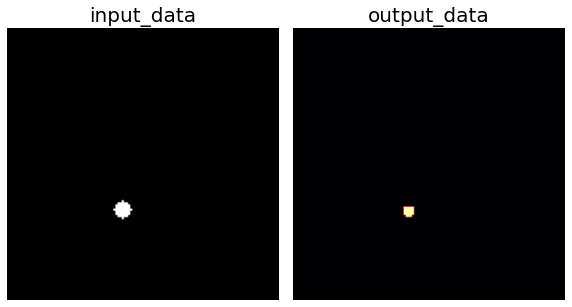

In [215]:
plotting.plot_comparison(labels_test[folder_name[0]][20], pred_labels_test[folder_name[0]][20])

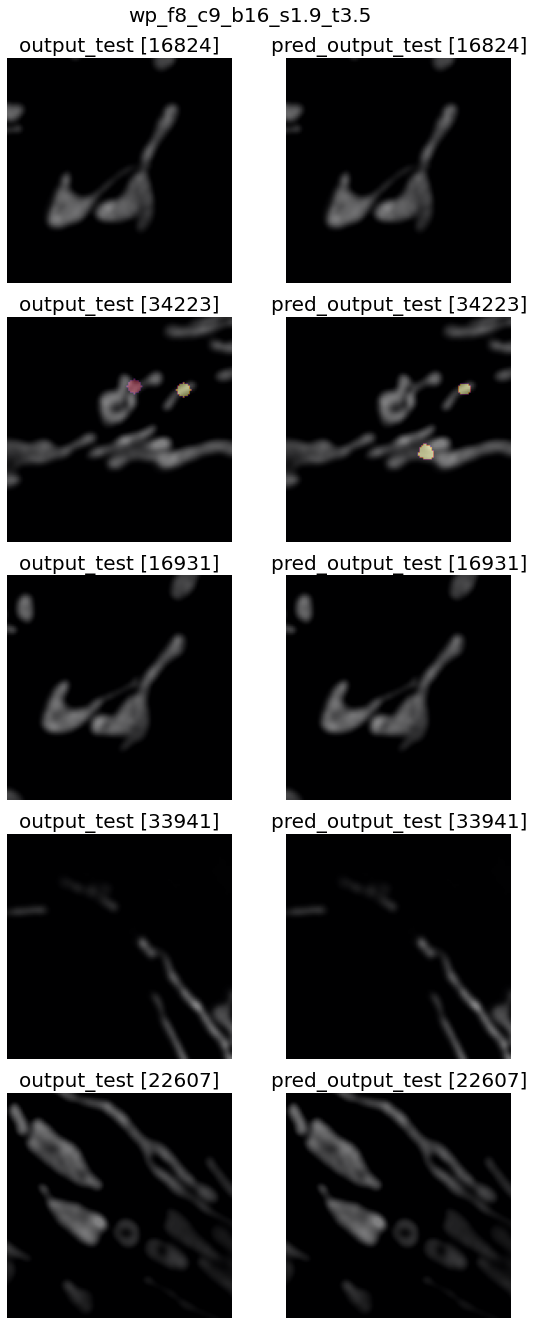

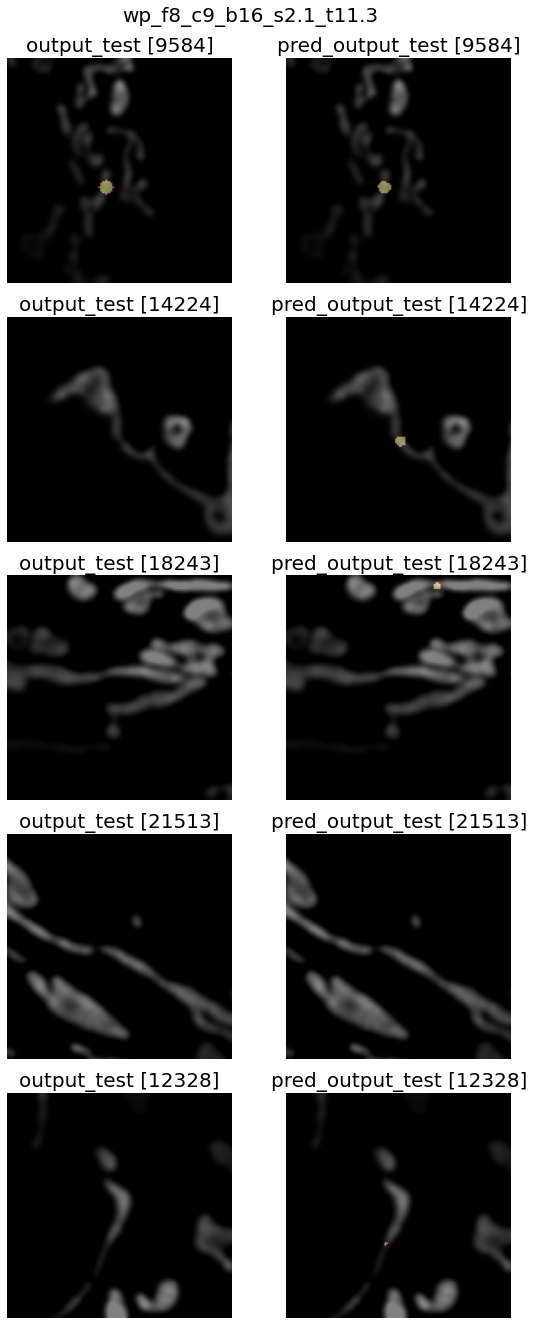

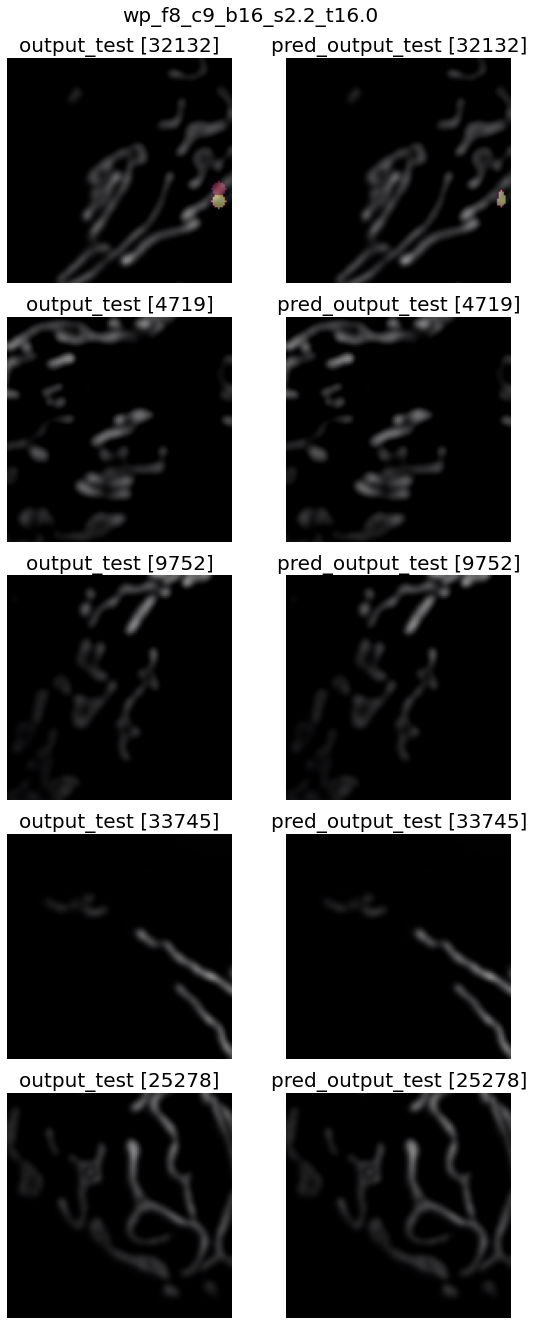

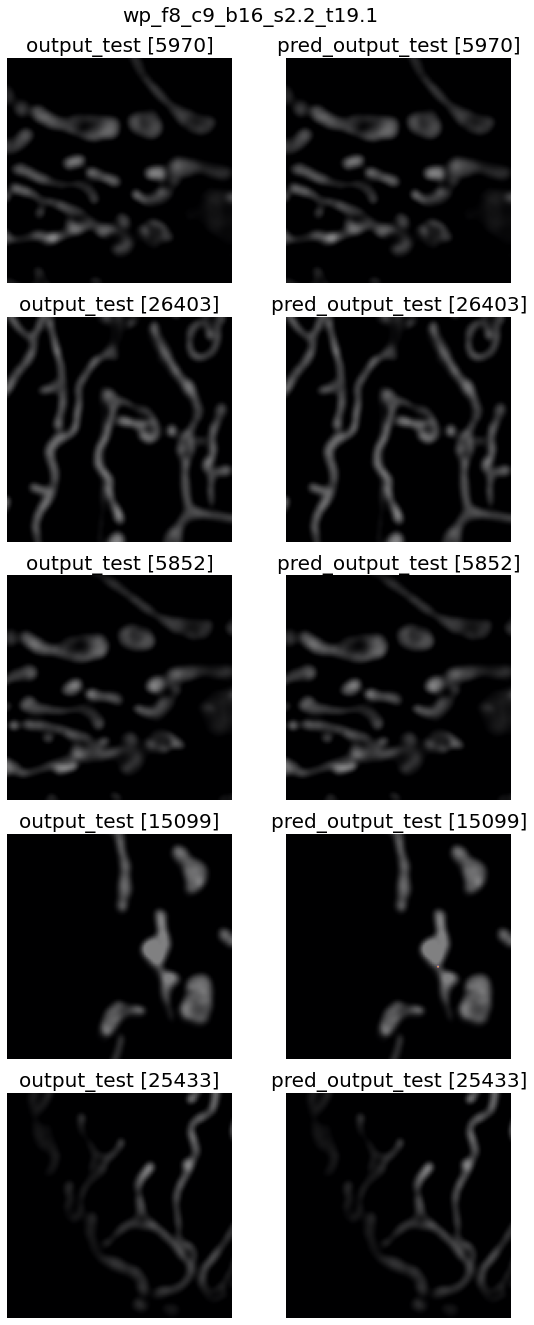

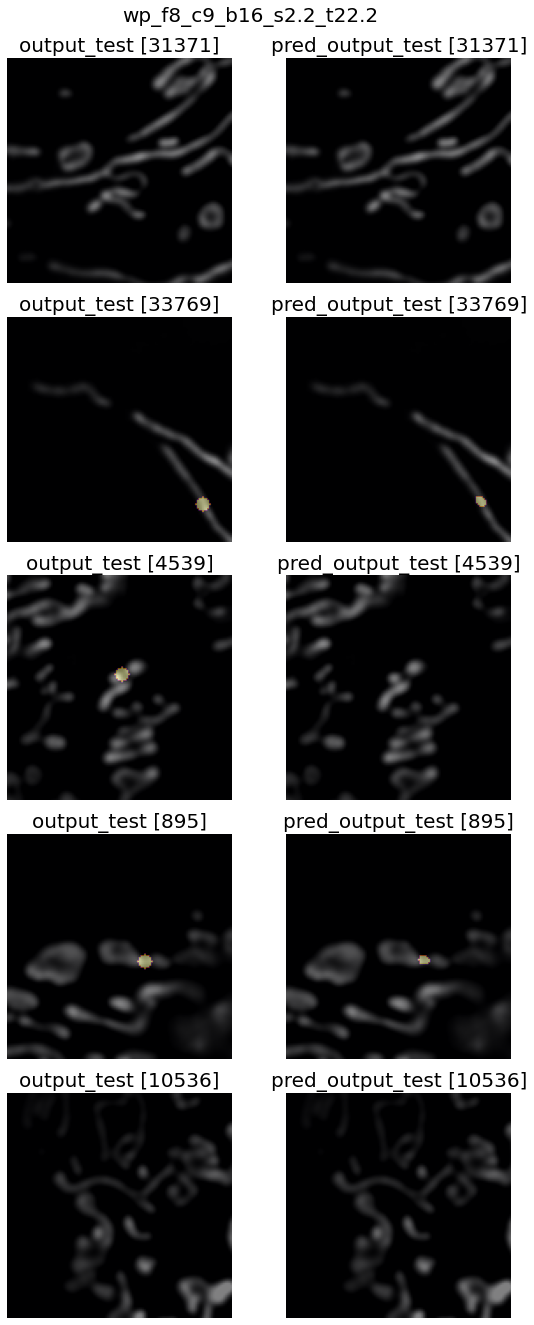

In [211]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], labels_test[model_name], 
                        pred_labels_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

In [132]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/wp_f8_c9_b16_s1.9_t3.5/metrics

Loading H:/Santi/Models/wp_f8_c9_b16_s2.1_t11.3/metrics

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t16.0/metrics

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t19.1/metrics

Loading H:/Santi/Models/wp_f8_c9_b16_s2.2_t22.2/metrics
Done.


### All metrics

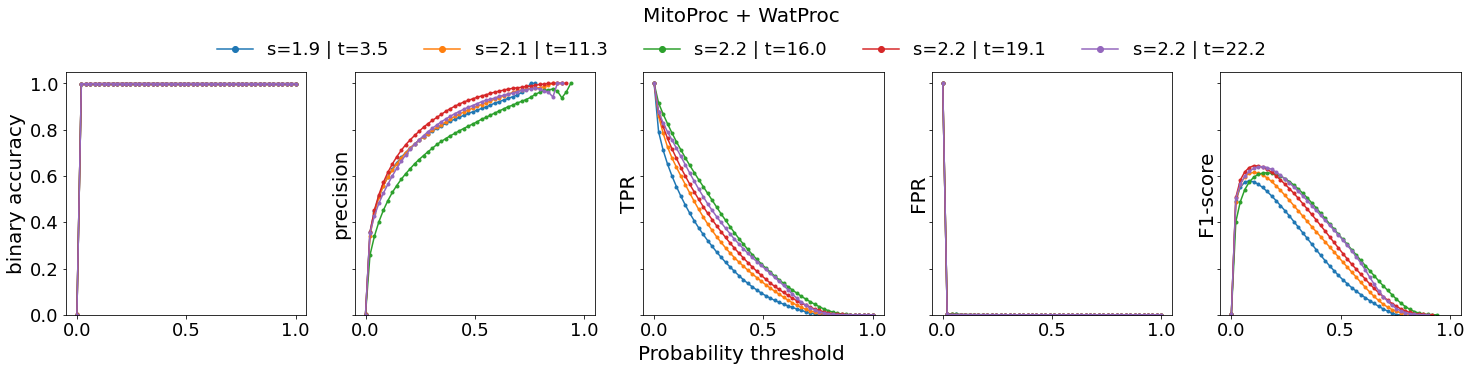

In [133]:
nb_models = len(metrics)
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_models))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)
fig.suptitle('MitoProc + WatProc', size=20, va='top')
for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], 'o-', color=color)[0] for color in colors], ['s=%.1f | t=%.1f'%(s, t) for s, t in zip(optimal_sigma, threshold)],
           loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=5, framealpha=0)
fig.subplots_adjust(top=0.8)
plt.show()

### metricAtMaxF1

In [134]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][metrics[model_name]['F1-score']==np.nanmax(metrics[model_name]['F1-score'])][0]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

wp_f8_c9_b16_s1.9_t3.5  wp_f8_c9_b16_s2.1_t11.3  \
binary accuracy                0.997640                 0.998637   
precision                      0.558499                 0.593759   
TPR                            0.599924                 0.637598   
FPR                            0.001283                 0.000746   
F1-score                       0.578470                 0.614898   

                 wp_f8_c9_b16_s2.2_t16.0  wp_f8_c9_b16_s2.2_t19.1  \
binary accuracy                 0.999014                 0.999237   
precision                       0.585407                 0.615019   
TPR                             0.645446                 0.676148   
FPR                             0.000556                 0.000433   
F1-score                        0.613962                 0.644136   

                 wp_f8_c9_b16_s2.2_t22.2  
binary accuracy                 0.999372  
precision                       0.633093  
TPR                             0.647923  
FPR                             0.000324  
F1-score                        0.640422

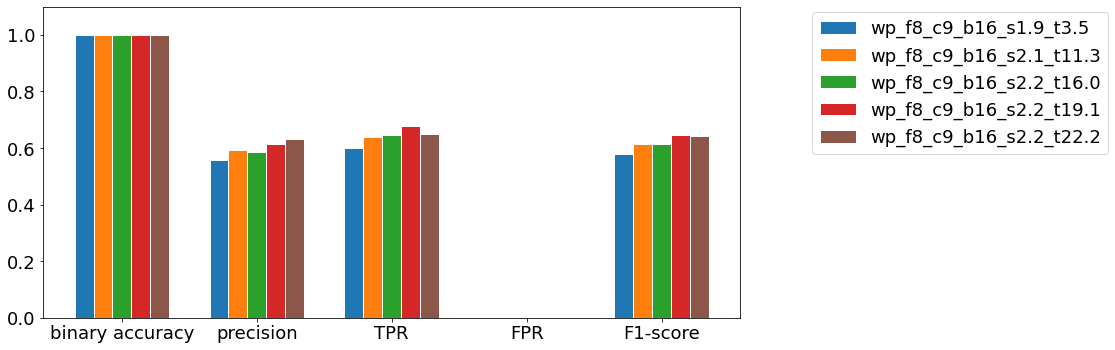

In [135]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'wp_f8_c9_b16_s1.9_t3.5': 0.0026989498653927366, 'wp_f8_c9_b16_s2.1_t11.3': 0.0017063037769214527, 'wp_f8_c9_b16_s2.2_t16.0': 0.001215259448902027, 'wp_f8_c9_b16_s2.2_t19.1': 0.0010218439875422298, 'wp_f8_c9_b16_s2.2_t22.2': 0.0008626412056587838}


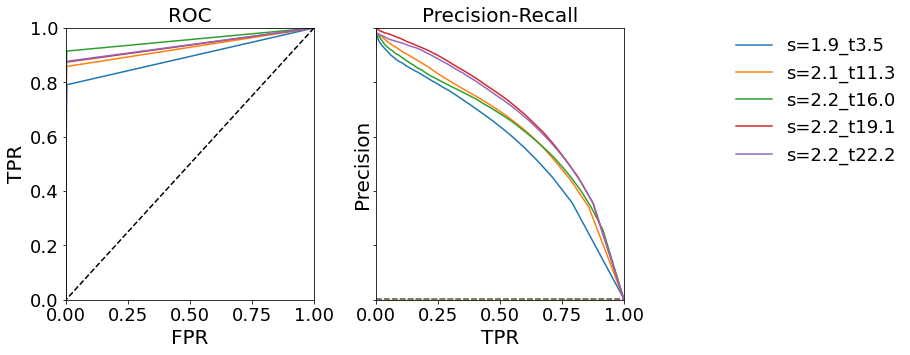

In [136]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

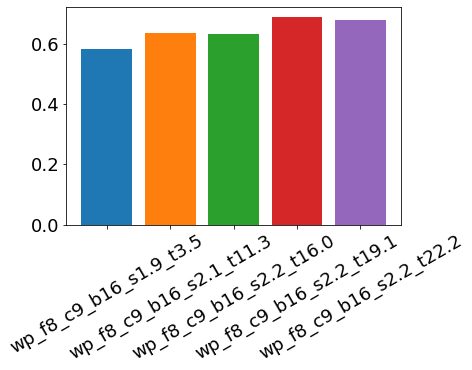

In [137]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

## MitoProc & WatProc, different spot sizes

Contrast enhancement of input data does not improve the performance

In [3]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = util.load_h5(data_path, 'MitoProc')
print('Inputs'+':', input_data.shape)

optimal_sigma = util.load_pkl(data_path, 'optimal_sigma')
threshold = util.load_pkl(data_path, 'mean_intensity_threshold')
nb_sigmas = optimal_sigma.shape[0]

#Outputs
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'wp_mp')


Loading H:/Santi/Data/MitoProc.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/optimal_sigma

Loading H:/Santi/Data/mean_intensity_threshold


In [4]:
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.9_t3.5/model.h5

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.1_t11.3/model.h5

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t16.0/model.h5

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t19.1/model.h5

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t22.2/model.h5
Done.

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.9_t3.5/history

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.1_t11.3/history

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t16.0/history

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t19.1/history

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t22.2/history
Done.

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.9_t3.5/frames_test

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.1_t11.3/frames_test

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t16.0/frames_test

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t19.1/frames_test

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t22.2/frames_test
Done.


In [28]:
with gpu:
  input_test, output_test, pred_output_test,  = {}, {}, {}
  labels_test, pred_labels_test = {}, {}

  for model_name, s, t in zip(folder_name, optimal_sigma, threshold):
    print('\nModel: %s'%model_name)
    input_test[model_name] = input_data[frames_test[model_name]]
    
    #Outputs
    output_test[model_name] = util.load_h5(data_path, 'WatProc_s%.1f_t%.1f'%(s, t), indices=indices)
    print('Outputs:', output_test[model_name].shape)

    pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])
        
  del input_data


Model: wp_mp_f8_c9_b16_s1.9_t3.5

Loading H:/Santi/Data/WatProc_s1.9_t3.5.h5
Converting to array
Outputs: (7400, 128, 128)

Loading H:/Santi/Data/proc_labels_s1.9_t3.5.h5
Converting to array

Loading H:/Santi/Data/proc_fission_props_s1.9_t3.5


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:09<00:00, 781.58it/s]



Model: wp_mp_f8_c9_b16_s2.1_t11.3

Loading H:/Santi/Data/WatProc_s2.1_t11.3.h5
Converting to array
Outputs: (7400, 128, 128)

Loading H:/Santi/Data/proc_labels_s2.1_t11.3.h5
Converting to array

Loading H:/Santi/Data/proc_fission_props_s2.1_t11.3


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7400/7400 [00:06<00:00, 1090.35it/s]



Model: wp_mp_f8_c9_b16_s2.2_t16.0

Loading H:/Santi/Data/WatProc_s2.2_t16.0.h5
Converting to array

Loading H:/Santi/Data/W.h5


OSError: Unable to open file (unable to open file: name = 'H:/Santi/Data/W.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

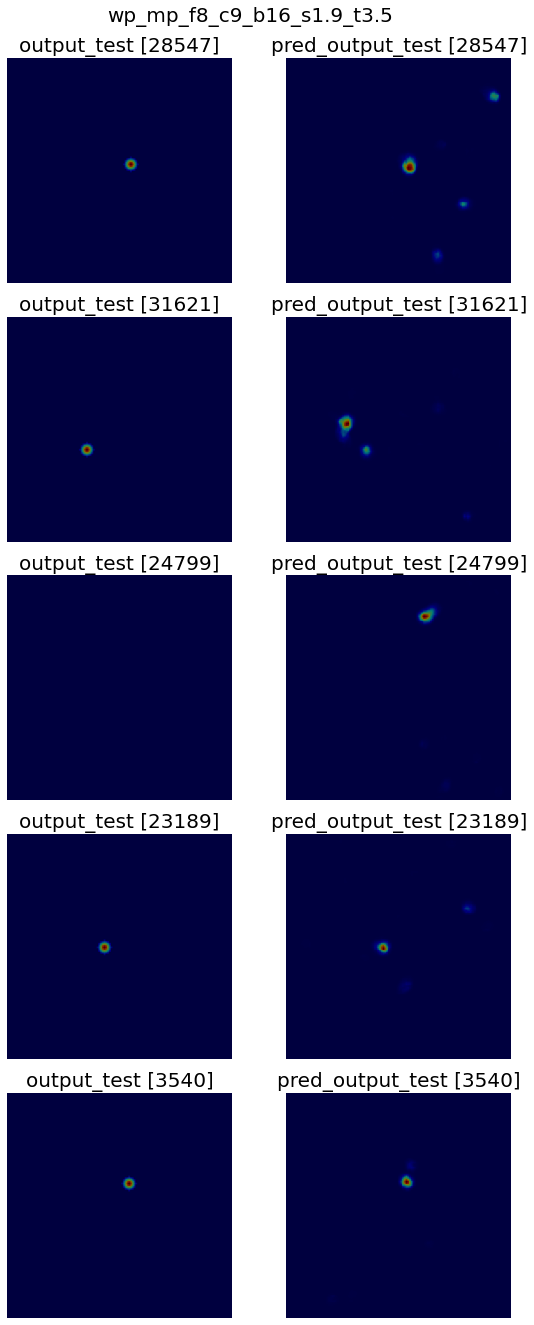

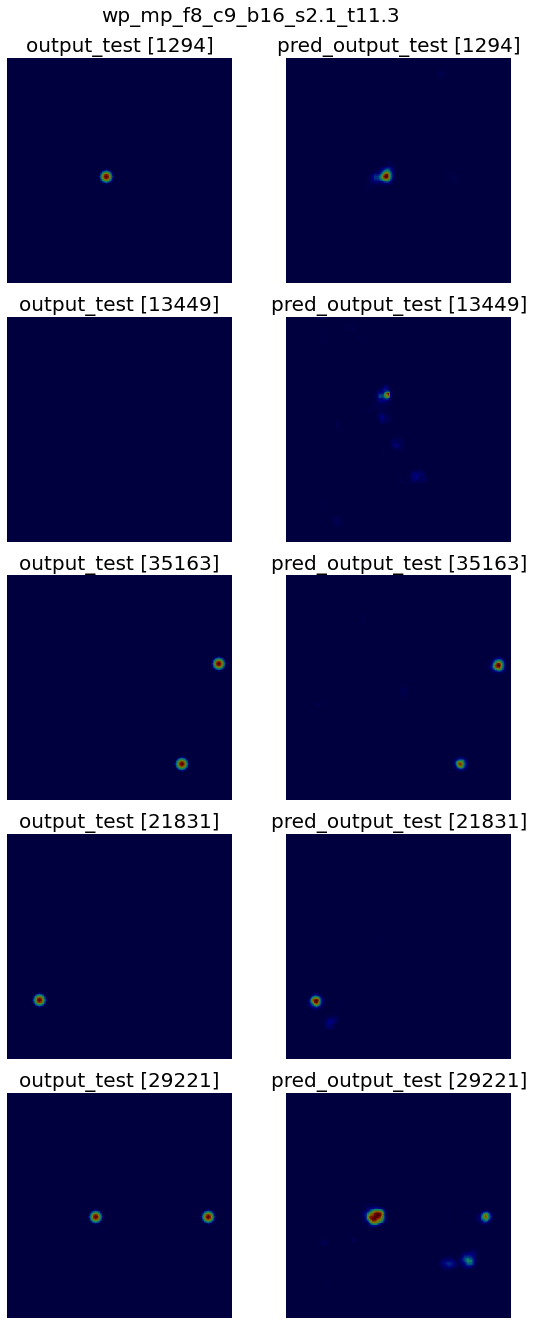

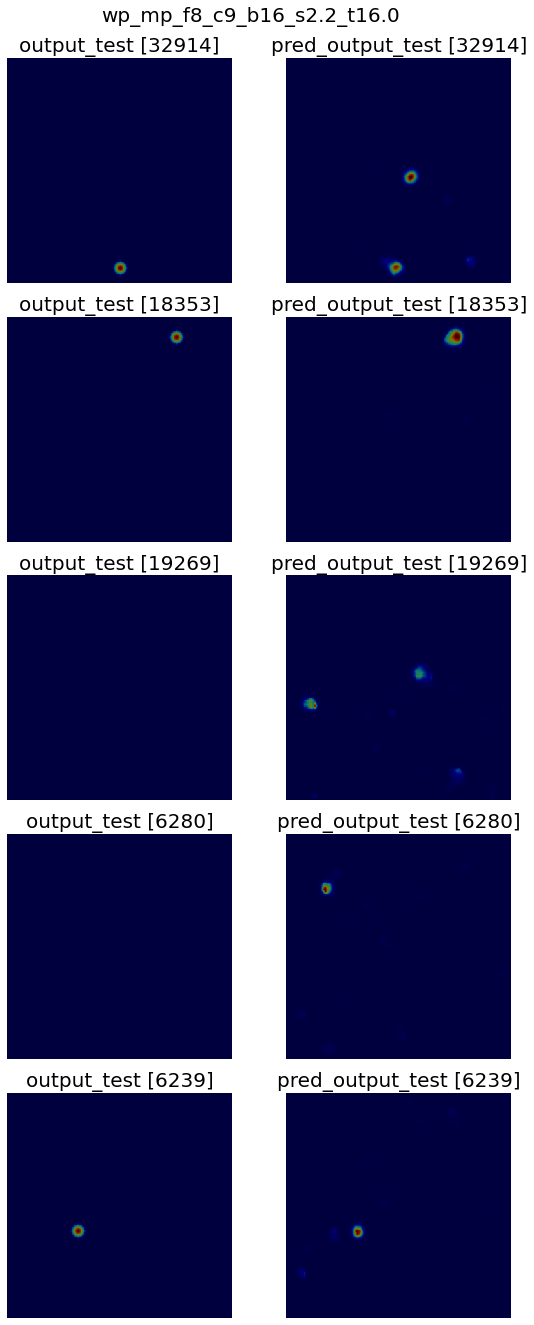

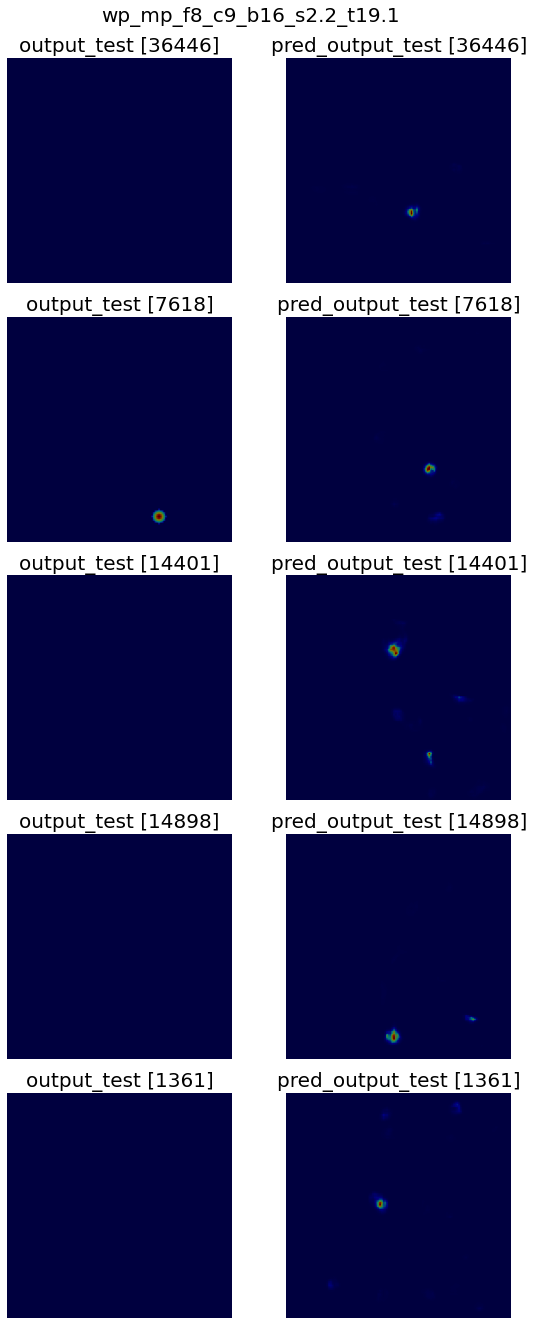

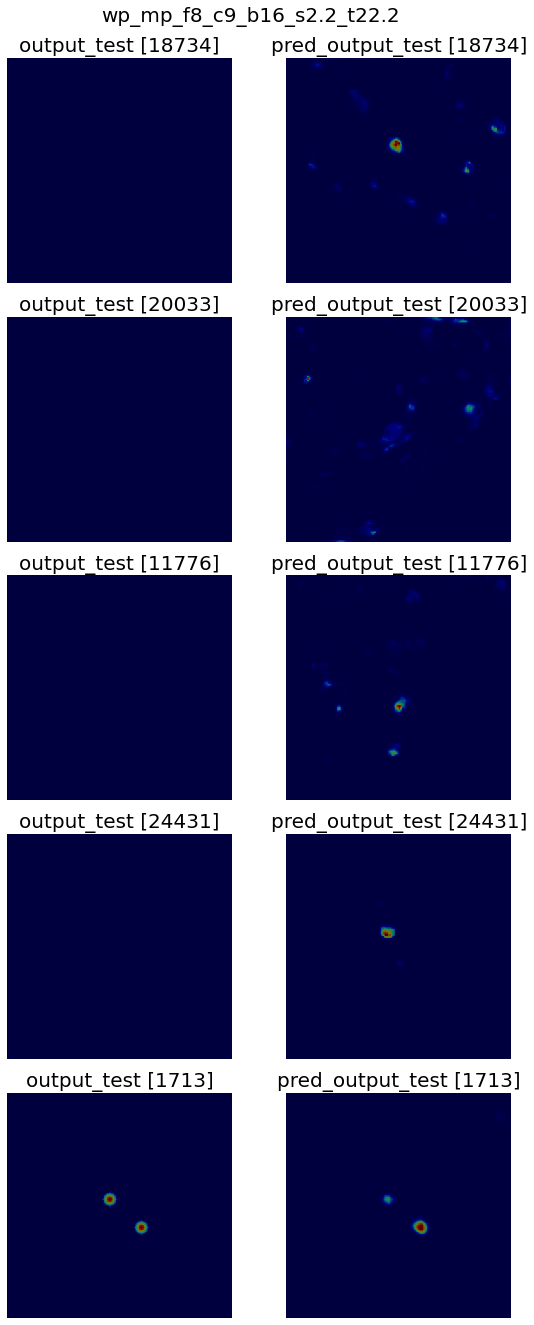

In [141]:
for model_name in folder_name:
  plotting.plot_outputs(0*input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'jet'])
  plt.show()
  print('\n')

In [142]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/wp_mp_f8_c9_b16_s1.9_t3.5/metrics

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.1_t11.3/metrics

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t16.0/metrics

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t19.1/metrics

Loading H:/Santi/Models/wp_mp_f8_c9_b16_s2.2_t22.2/metrics
Done.


### All metrics

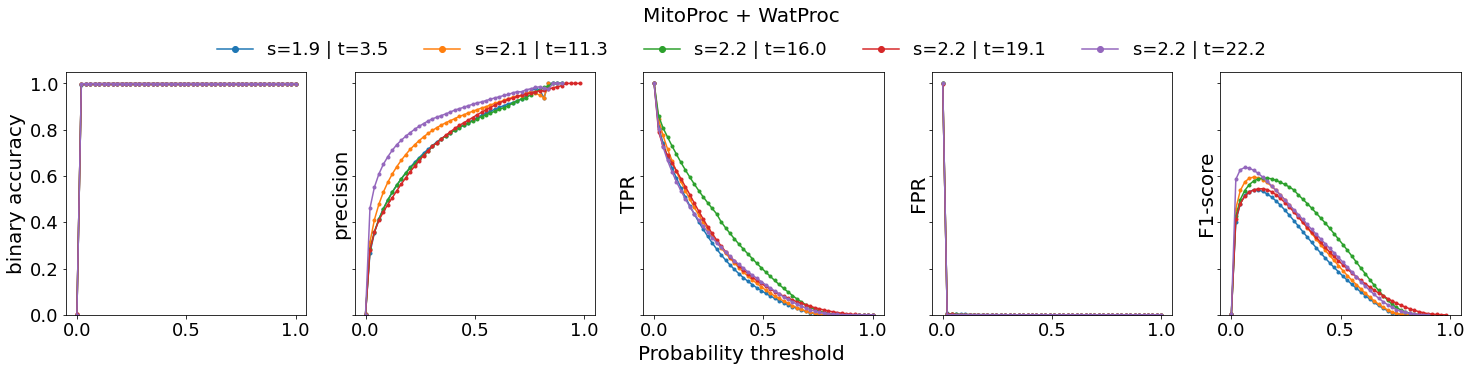

In [143]:
nb_models = len(metrics)
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_models))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)
fig.suptitle('MitoProc + WatProc', size=20, va='top')
for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], 'o-', color=color)[0] for color in colors], ['s=%.1f | t=%.1f'%(s, t) for s, t in zip(optimal_sigma, threshold)],
           loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=5, framealpha=0)
fig.subplots_adjust(top=0.8)
plt.show()

### metricAtMaxF1

In [144]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][metrics[model_name]['F1-score']==np.nanmax(metrics[model_name]['F1-score'])][0]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

wp_mp_f8_c9_b16_s1.9_t3.5  wp_mp_f8_c9_b16_s2.1_t11.3  \
binary accuracy                   0.997340                    0.998611   
precision                         0.496127                    0.572585   
TPR                               0.590897                    0.619432   
FPR                               0.001586                    0.000763   
F1-score                          0.539381                    0.595088   

                 wp_mp_f8_c9_b16_s2.2_t16.0  wp_mp_f8_c9_b16_s2.2_t19.1  \
binary accuracy                    0.998938                    0.999083   
precision                          0.560177                    0.535637   
TPR                                0.625857                    0.553856   
FPR                                0.000603                    0.000476   
F1-score                           0.591199                    0.544594   

                 wp_mp_f8_c9_b16_s2.2_t22.2  
binary accuracy                    0.999349  
precision                          0.608412  
TPR                                0.667272  
FPR                                0.000367  
F1-score                           0.636484

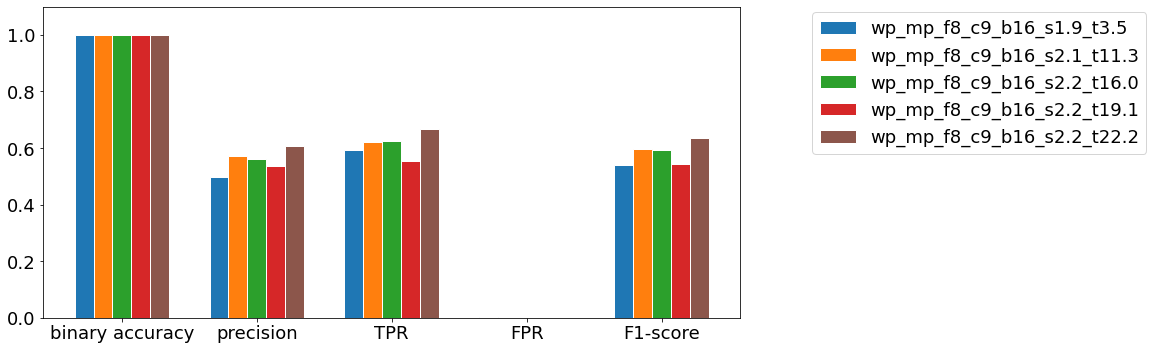

In [145]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'wp_mp_f8_c9_b16_s1.9_t3.5': 0.0026358692066089525, 'wp_mp_f8_c9_b16_s2.1_t11.3': 0.0016482626425253378, 'wp_mp_f8_c9_b16_s2.2_t16.0': 0.0012264767208614864, 'wp_mp_f8_c9_b16_s2.2_t19.1': 0.000990344898120777, 'wp_mp_f8_c9_b16_s2.2_t22.2': 0.0008540055558488175}


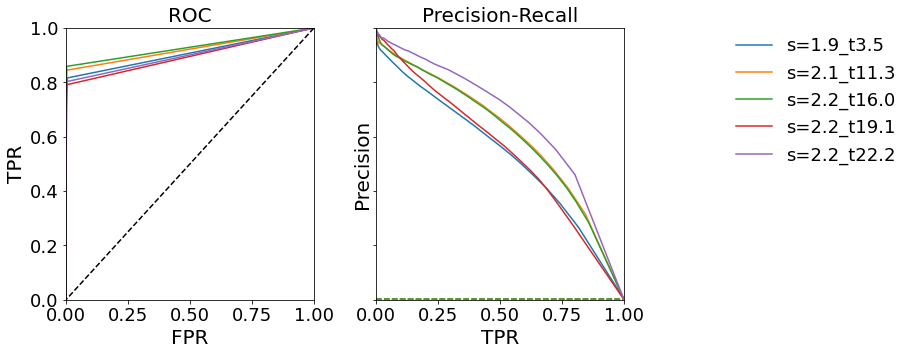

In [146]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

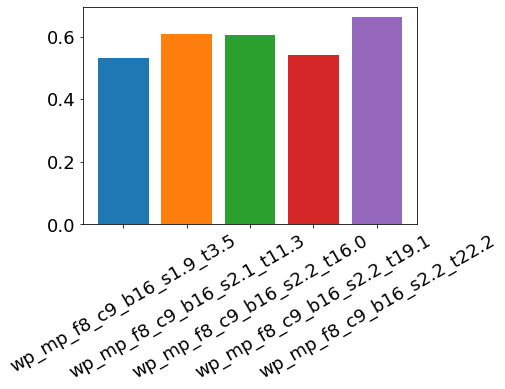

In [147]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

## Augmented Mito and WatProc

In [148]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

optimal_sigma = util.load_pkl(data_path, 'optimal_sigma')
threshold = util.load_pkl(data_path, 'mean_intensity_threshold')
nb_sigmas = optimal_sigma.shape[0]

#Inputs
input_data = util.load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
model_path = base_dir + 'Models/'
folder_name = util.get_filename(model_path, 'aug_wp')


Loading H:/Santi/Data/optimal_sigma

Loading H:/Santi/Data/mean_intensity_threshold

Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)


In [149]:
nb_models = len(folder_name)

model = util.load_model(model_path, ['model']*nb_models, folder_name, as_type=dict)
history = util.load_pkl(model_path, ['history']*nb_models, folder_name, as_type=dict)
frames_test = util.load_pkl(model_path, ['frames_test']*nb_models, folder_name, as_type=dict)


Loading H:/Santi/Models/aug_wp_f8_c9_b16_s1.9_t3.5/model.h5

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.1_t11.3/model.h5

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t16.0/model.h5

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t19.1/model.h5

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t22.2/model.h5
Done.

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s1.9_t3.5/history

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.1_t11.3/history

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t16.0/history

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t19.1/history

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t22.2/history
Done.

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s1.9_t3.5/frames_test

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.1_t11.3/frames_test

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t16.0/frames_test

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t19.1/frames_test

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t22.2/frames_test
Done.


In [150]:
with gpu:
  input_test, output_test, pred_output_test = {}, {}, {}

  for model_name, s, t in zip(folder_name, optimal_sigma, threshold):
    print('\nModel: %s'%model_name)
    
    #Outputs
    output_data = util.load_h5(data_path, 'WatProc_s%.1f_t%.1f'%(s, t))
    print('Outputs:', output_data.shape)
    output_test[model_name] = output_data[frames_test[model_name]]
    del output_data
    
    #Inputs
    input_test[model_name] = input_data[frames_test[model_name]]
    
    pred_output_test[model_name] = evaluation.predict(input_test[model_name], model[model_name])

del input_data


Model: aug_wp_f8_c9_b16_s1.9_t3.5

Loading H:/Santi/Data/WatProc_s1.9_t3.5.h5
Converting to array
Outputs: (37000, 128, 128)

Model: aug_wp_f8_c9_b16_s2.1_t11.3

Loading H:/Santi/Data/WatProc_s2.1_t11.3.h5
Converting to array
Outputs: (37000, 128, 128)

Model: aug_wp_f8_c9_b16_s2.2_t16.0

Loading H:/Santi/Data/WatProc_s2.2_t16.0.h5
Converting to array
Outputs: (37000, 128, 128)

Model: aug_wp_f8_c9_b16_s2.2_t19.1

Loading H:/Santi/Data/WatProc_s2.2_t19.1.h5
Converting to array
Outputs: (37000, 128, 128)

Model: aug_wp_f8_c9_b16_s2.2_t22.2

Loading H:/Santi/Data/WatProc_s2.2_t22.2.h5
Converting to array
Outputs: (37000, 128, 128)


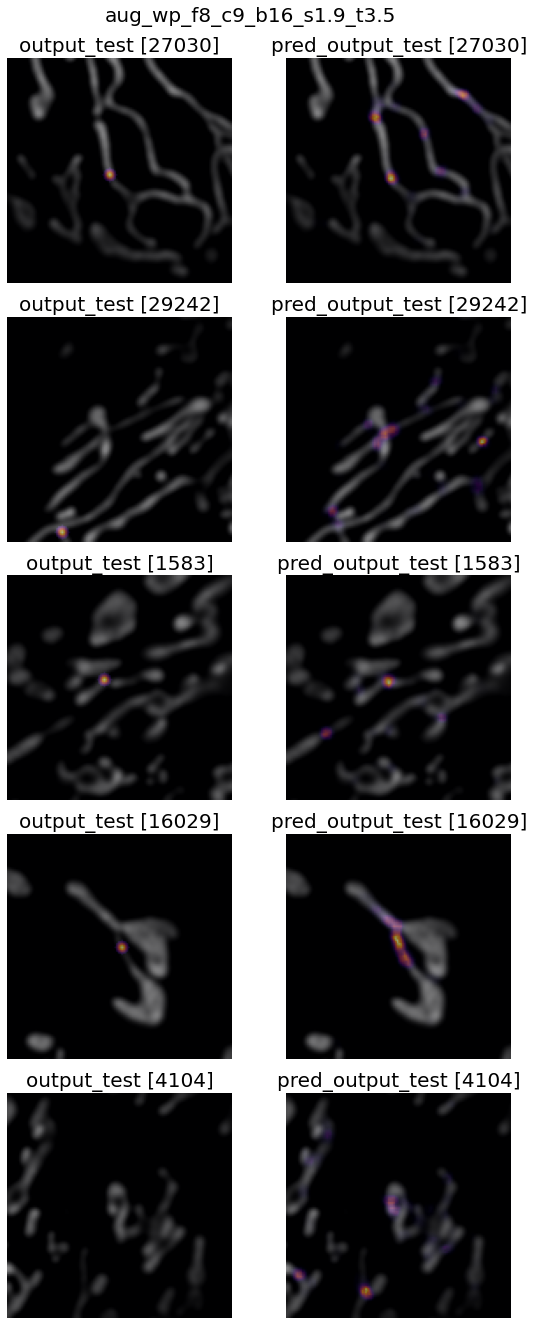

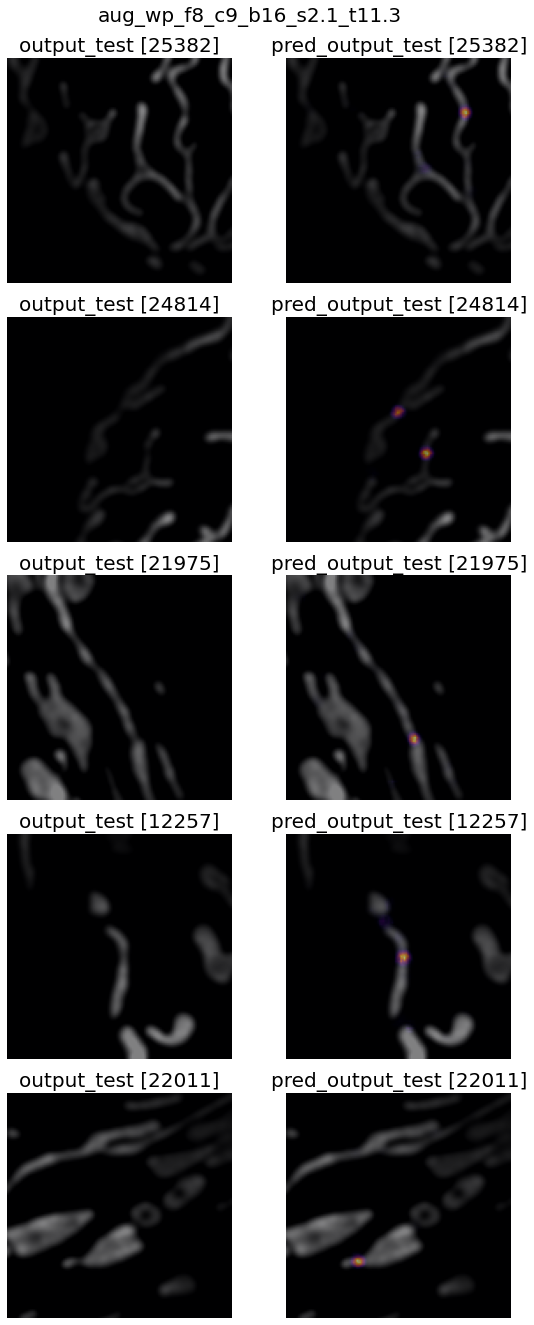

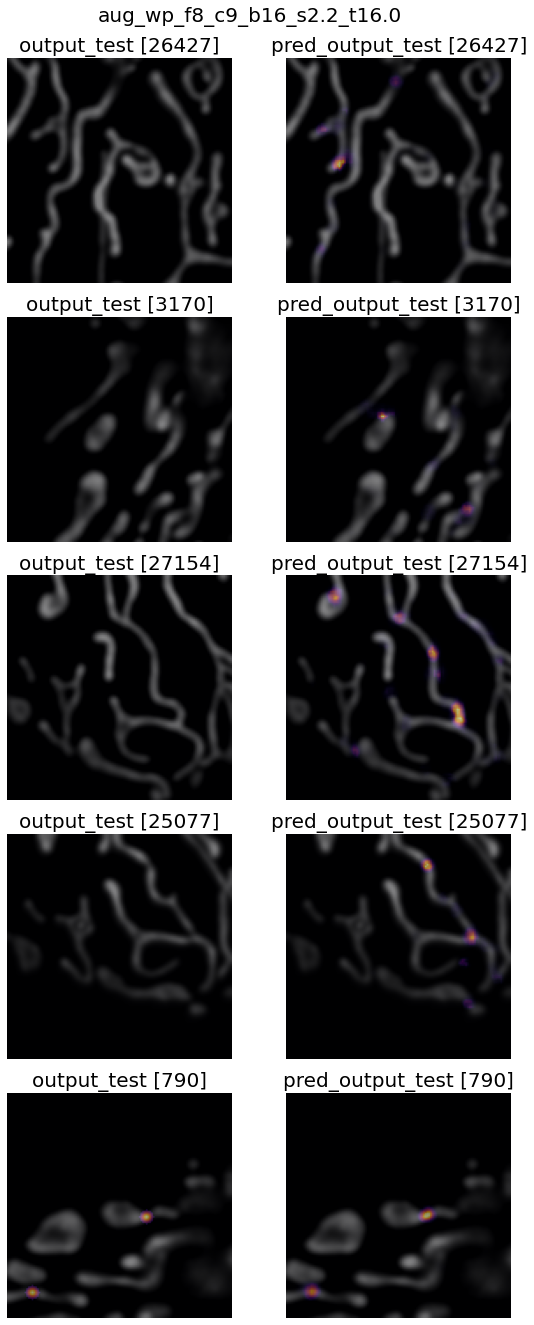

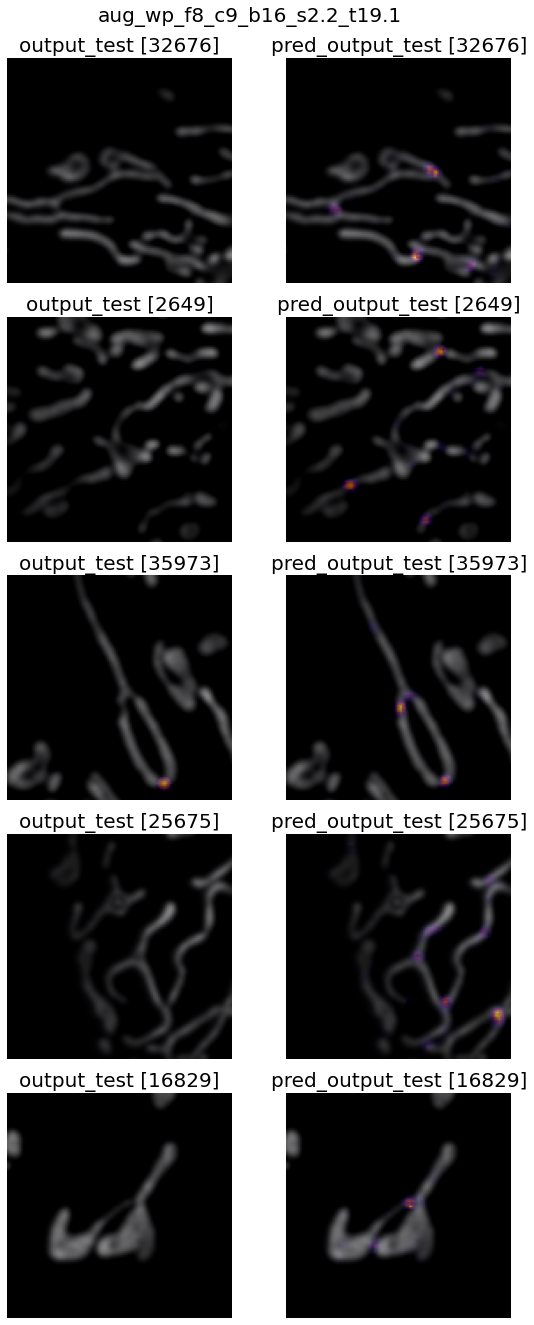

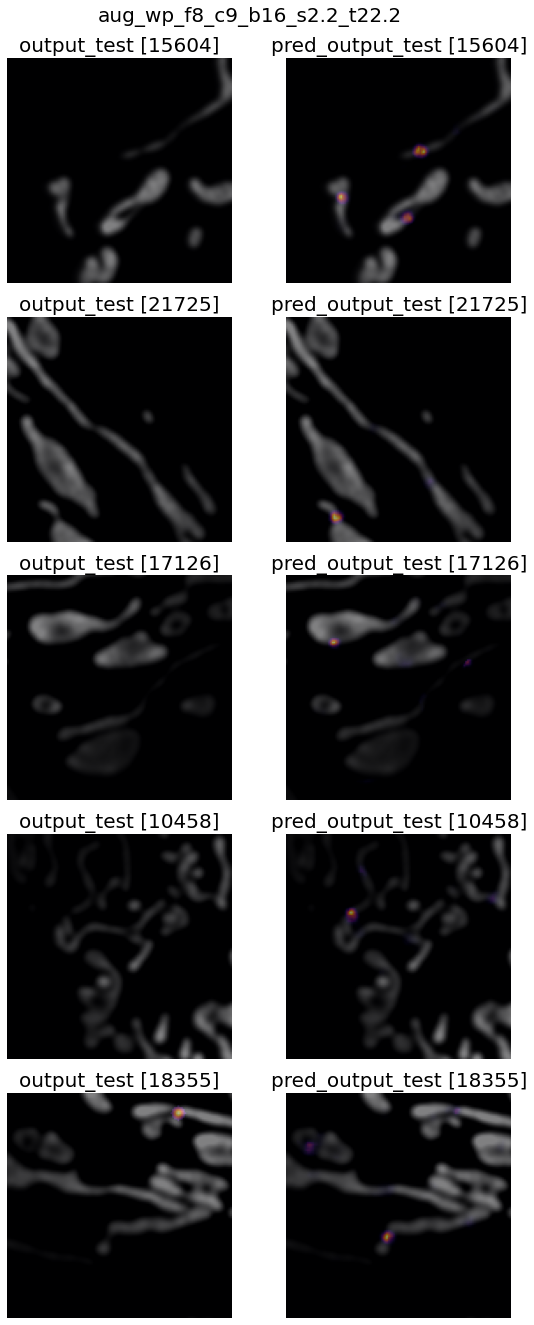

In [151]:
for model_name in folder_name:
  plotting.plot_outputs(input_test[model_name], output_test[model_name], pred_output_test[model_name], frames_test[model_name], 
                        nb_examples=5, title=model_name, cmap=['gray', 'inferno'])
  plt.show()
  print('\n')

In [7]:
metrics = {}
thresholds = np.linspace(0, 1, 50, endpoint=True)

for model_name in folder_name:
  det_match = evaluation.detection_match(output_test[model_name], pred_output_test[model_name], threshold=1)
  print('%s: %.2f'%(model_name, det_match))
  metrics[model_name] = evaluation.get_metrics(output_test[model_name], pred_output_test[model_name], thresholds)
util.save_pkl(metrics, model_path, ['metrics']*len(folder_name), folder_name)

aug_wp_f8_c9_b16_s1.9_t3.5: 0.46


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.29it/s]
C:\Users\snrodrig\Documents\GitHub\MitoSplit-Net\mitosplit-net\evaluation.py:64: RuntimeWarning: invalid value encountered in true_divide
  'precision': tp/(tp+fp),


aug_wp_f8_c9_b16_s2.1_t11.3: 0.62


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:39<00:00,  1.27it/s]


aug_wp_f8_c9_b16_s2.2_t16.0: 0.70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.30it/s]


aug_wp_f8_c9_b16_s2.2_t19.1: 0.75


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.30it/s]


aug_wp_f8_c9_b16_s2.2_t22.2: 0.77


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.29it/s]


Saving H:/Santi/Models/aug_wp_f8_c9_b16_s1.9_t3.5/metrics

Saving H:/Santi/Models/aug_wp_f8_c9_b16_s2.1_t11.3/metrics

Saving H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t16.0/metrics

Saving H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t19.1/metrics

Saving H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t22.2/metrics
Done.


In [152]:
thresholds = np.linspace(0, 1, 50, endpoint=True)
metrics = util.load_pkl(model_path, ['metrics']*len(folder_name), folder_name, as_type=dict)


Loading H:/Santi/Models/aug_wp_f8_c9_b16_s1.9_t3.5/metrics

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.1_t11.3/metrics

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t16.0/metrics

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t19.1/metrics

Loading H:/Santi/Models/aug_wp_f8_c9_b16_s2.2_t22.2/metrics
Done.


### All metrics

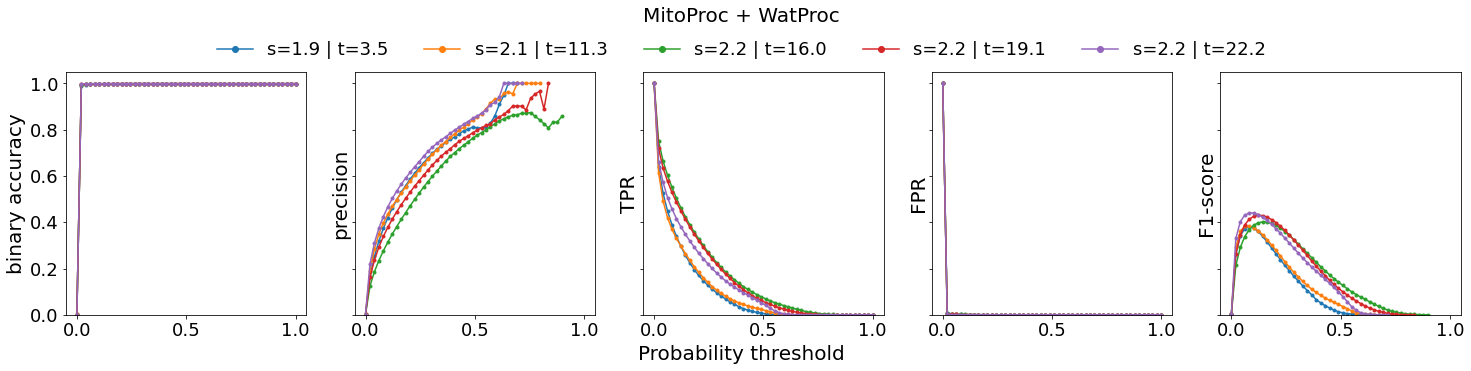

In [153]:
nb_models = len(metrics)
nb_metrics = len(metrics[folder_name[0]])
colors = plt.cm.get_cmap('tab10')(range(nb_models))

fig, axes = plt.subplots(1, nb_metrics, figsize=(5*nb_metrics, 5), sharex=True, sharey=True)
fig.suptitle('MitoProc + WatProc', size=20, va='top')
for model_name, color in zip(folder_name, colors):
  for metric_name, ax in zip(metrics[model_name], axes):
    ax.plot(thresholds, metrics[model_name][metric_name], 'o-', markersize=3, color=color)
    ax.set_ylabel(metric_name)
    ax.set_ylim([0, 1.05])
fig.text(0.5, 0, 'Probability threshold', fontsize=20, ha='center')
fig.legend([plt.plot([], 'o-', color=color)[0] for color in colors], ['s=%.1f | t=%.1f'%(s, t) for s, t in zip(optimal_sigma, threshold)],
           loc='upper center', bbox_to_anchor=(0.5, 0.93), ncol=5, framealpha=0)
fig.subplots_adjust(top=0.8)
plt.show()

### metricAtMaxF1

In [154]:
metricsAtMaxThreshold = pd.DataFrame({model_name: {metric_name: metrics[model_name][metric_name][metrics[model_name]['F1-score']==np.nanmax(metrics[model_name]['F1-score'])][0]  for metric_name in metrics[model_name]} \
                                      for model_name in folder_name})
metricsAtMaxThreshold

aug_wp_f8_c9_b16_s1.9_t3.5  aug_wp_f8_c9_b16_s2.1_t11.3  \
binary accuracy                    0.996588                     0.997967   
precision                          0.373165                     0.397087   
TPR                                0.388671                     0.369378   
FPR                                0.001767                     0.000959   
F1-score                           0.380761                     0.382731   

                 aug_wp_f8_c9_b16_s2.2_t16.0  aug_wp_f8_c9_b16_s2.2_t19.1  \
binary accuracy                     0.998464                     0.998786   
precision                           0.381189                     0.413427   
TPR                                 0.423768                     0.448559   
FPR                                 0.000837                     0.000651   
F1-score                            0.401352                     0.430277   

                 aug_wp_f8_c9_b16_s2.2_t22.2  
binary accuracy                     0.998997  
precision                           0.424626  
TPR                                 0.457337  
FPR                                 0.000535  
F1-score                            0.440375

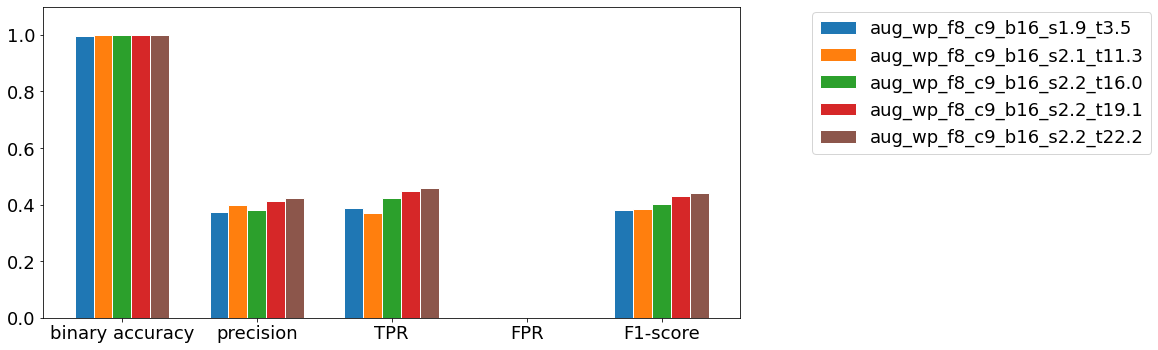

In [155]:
ax = plotting.plot_metrics_comparison(metricsAtMaxThreshold, xscale=2.5, yscale=1.1)
plt.show()

### ROC and Precision-Recall curves


Fraction of positives
{'aug_wp_f8_c9_b16_s1.9_t3.5': 0.0026989498653927366, 'aug_wp_f8_c9_b16_s2.1_t11.3': 0.0017063037769214527, 'aug_wp_f8_c9_b16_s2.2_t16.0': 0.001215259448902027, 'aug_wp_f8_c9_b16_s2.2_t19.1': 0.0010218439875422298, 'aug_wp_f8_c9_b16_s2.2_t22.2': 0.0008626412056587838}


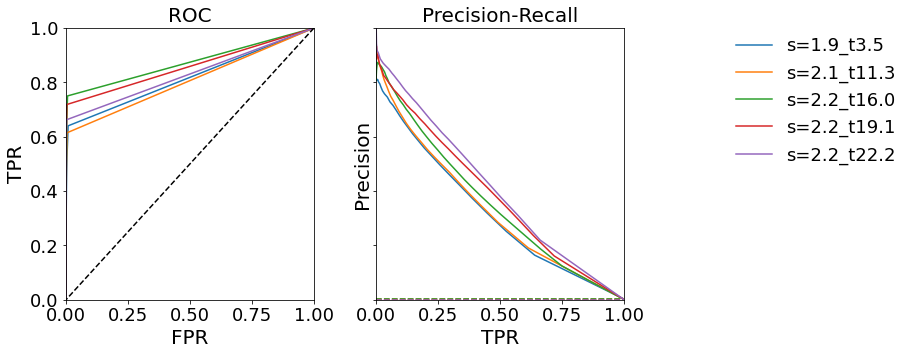

In [156]:
plotting.plot_performance_curves(metrics, output_test, colors=colors)
plt.show()

### Precision-Recall AUC

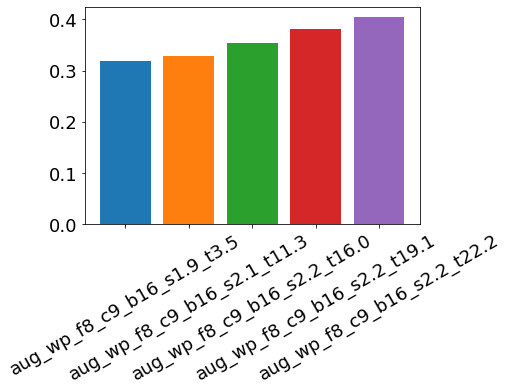

In [157]:
AUC = evaluation.get_AUC(metrics)
xticks = range(len(AUC))

fig, ax = plt.subplots()
ax.bar(xticks, list(AUC.values()), color=colors)
ax.set_xticks(xticks)
ax.set_xticklabels(list(AUC.keys()), rotation=30)
plt.show()

### Labels binary overlap